# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef as phi_coef
import json
from torch import save, load

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [3]:
seed = 2609612152#randint(0, 4294967295) #60412887
print(seed)

2609612152


In [4]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure', 
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
0  70.0  1.0         4.0           130.0        322.0          0.0   
1  67.0  0.0         3.0           115.0        564.0          0.0   
2  57.0  1.0         2.0           124.0        261.0          0.0   
3  64.0  1.0         4.0           128.0        263.0          0.0   
4  74.0  0.0         2.0           120.0        269.0          0.0   

   eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
0             2.0           109.0          0.0      2.4         2.0   
1             2.0           160.0          0.0      1.6         2.0   
2             0.0           141.0          0.0      0.3         1.0   
3             0.0           105.0          1.0      0.2         2.0   
4             2.0           121.0          1.0      0.2         1.0   

   major_vessels  thal  target  
0            3.0   3.0       1  
1            0.0   7.0       0  
2            0.0   7.0       1  
3            1.0   7.0       0  
4            1.0   3.0       0

<Axes: >

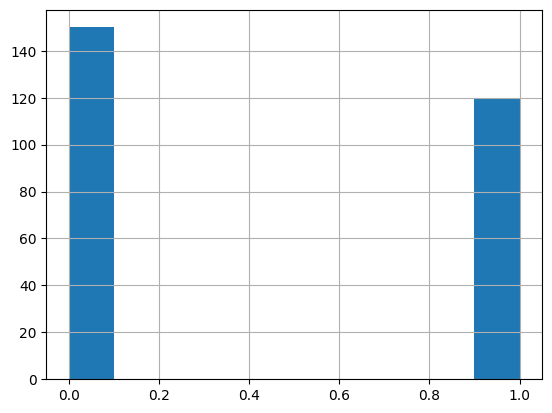

In [5]:
df['target'].hist()

<Axes: >

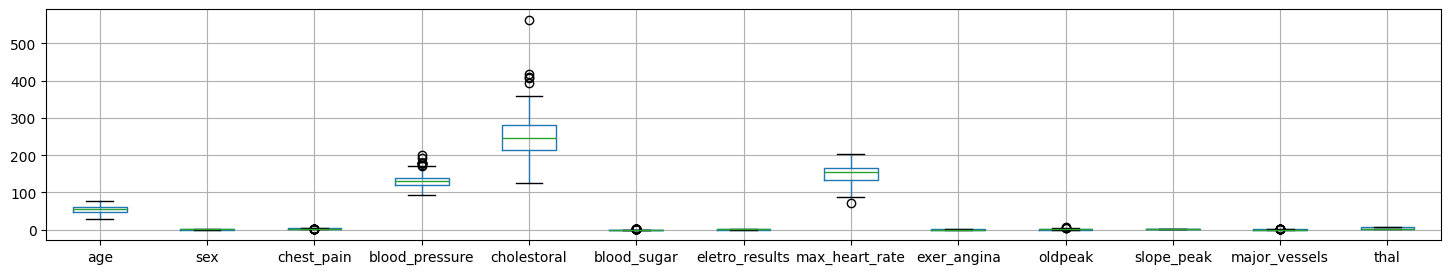

In [6]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

<Axes: >

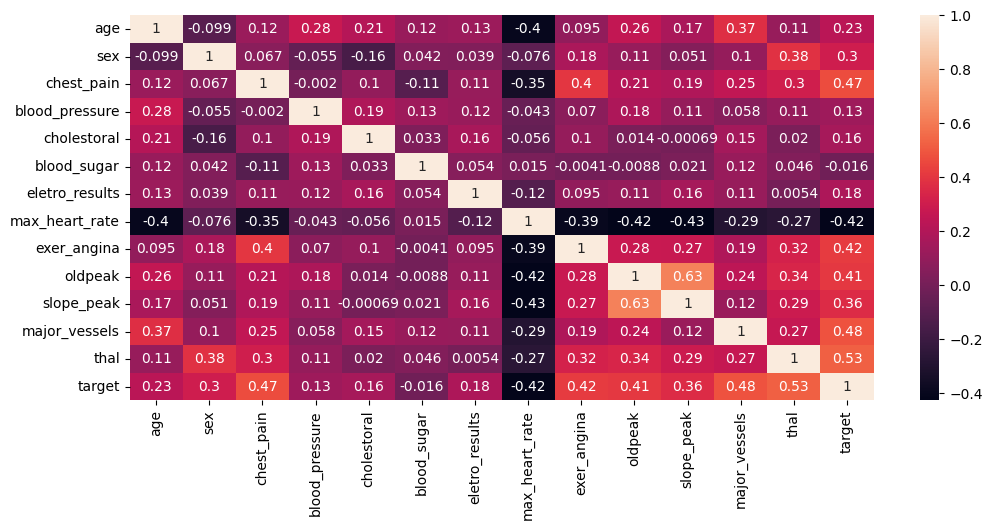

In [7]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('spearman'), annot=True)

In [8]:
df.corr('spearman').dtypes

age               float64
sex               float64
chest_pain        float64
blood_pressure    float64
cholestoral       float64
blood_sugar       float64
eletro_results    float64
max_heart_rate    float64
exer_angina       float64
oldpeak           float64
slope_peak        float64
major_vessels     float64
thal              float64
target            float64
dtype: object

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [9]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [10]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

In [11]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [12]:
performs = {}
models_error = pd.DataFrame()
models = []

In [13]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [14]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [15]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.8404
Recall:           0.9362
Precision:        0.7857
F1:               0.8544
AUROC:            0.9108
AUPR:             0.8889
1-maxProb média:  0.1596
1-maxProb dp:     0.1609

[Testing]

Accuracy:         0.7474
Recall:           0.9459
Precision:        0.6140
F1:               0.7447
AUROC:            0.8318
AUPR:             0.6766
1-maxProb média:  0.1787
1-maxProb dp:     0.1596


In [16]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0  0.357143
1  0.965517
2  0.357143
3  0.461538
4  0.078947

In [17]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [18]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'log_loss', 'penalty': 'l1'}


In [19]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.8936
Recall:           0.8511
Precision:        0.9302
F1:               0.8889
AUROC:            0.9670
AUPR:             0.9704
1-maxProb média:  0.1241
1-maxProb dp:     0.1313

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8700
AUPR:             0.7426
1-maxProb média:  0.1531
1-maxProb dp:     0.1398


### Logistic Regression

In [20]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [21]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.8723
Recall:           0.8298
Precision:        0.9070
F1:               0.8667
AUROC:            0.9593
AUPR:             0.9632
1-maxProb média:  0.1991
1-maxProb dp:     0.1231

[Testing]

Accuracy:         0.8000
Recall:           0.7838
Precision:        0.7250
F1:               0.7532
AUROC:            0.8914
AUPR:             0.8023
1-maxProb média:  0.2386
1-maxProb dp:     0.1275


### K-Nearest Neighbors

(KNN)

In [22]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'uniform'}


In [23]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

[Training]

Accuracy:         0.8617
Recall:           0.7872
Precision:        0.9250
F1:               0.8506
AUROC:            0.9350
AUPR:             0.9311
1-maxProb média:  0.1996
1-maxProb dp:     0.1341

[Testing]

Accuracy:         0.8421
Recall:           0.7838
Precision:        0.8056
F1:               0.7945
AUROC:            0.9091
AUPR:             0.8460
1-maxProb média:  0.2198
1-maxProb dp:     0.1426


### Support Vector Machine - Linear
(SVM)

In [24]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 0.1}


In [25]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.8723
Recall:           0.8511
Precision:        0.8889
F1:               0.8696
AUROC:            0.9588
AUPR:             0.9610
1-maxProb média:  0.1726
1-maxProb dp:     0.1209

[Testing]

Accuracy:         0.7474
Recall:           0.7838
Precision:        0.6444
F1:               0.7073
AUROC:            0.8681
AUPR:             0.7761
1-maxProb média:  0.2227
1-maxProb dp:     0.1389


### Support Vector Machine - Polynomial
(SVM)

In [26]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 1, 'degree': 3, 'gamma': 'scale'}


In [27]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9574
Recall:           0.9362
Precision:        0.9778
F1:               0.9565
AUROC:            0.9923
AUPR:             0.9932
1-maxProb média:  0.1359
1-maxProb dp:     0.1205

[Testing]

Accuracy:         0.7474
Recall:           0.7297
Precision:        0.6585
F1:               0.6923
AUROC:            0.8476
AUPR:             0.6949
1-maxProb média:  0.2237
1-maxProb dp:     0.1472


### Support Vector Machine - RBF
(SVM)

In [28]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [29]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.9362
Recall:           0.9362
Precision:        0.9362
F1:               0.9362
AUROC:            0.9896
AUPR:             0.9901
1-maxProb média:  0.1207
1-maxProb dp:     0.0916

[Testing]

Accuracy:         0.7895
Recall:           0.8108
Precision:        0.6977
F1:               0.7500
AUROC:            0.9035
AUPR:             0.8677
1-maxProb média:  0.2082
1-maxProb dp:     0.1550


### Multi-Layer Perceptron
(MLP)

In [30]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'solver': 'sgd'}


In [31]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.9255
Recall:           0.9149
Precision:        0.9348
F1:               0.9247
AUROC:            0.9846
AUPR:             0.9856
1-maxProb média:  0.1262
1-maxProb dp:     0.1304

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8774
AUPR:             0.7919
1-maxProb média:  0.1676
1-maxProb dp:     0.1431


### Kolmogorov-Arnold Network
(KAN)

In [32]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [33]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/heart.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/heart.pkl')
    save(kanet.state_dict(), 'kan_params/heart.pt')
else:
    with open('kan_params/heart.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/heart.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

width: [[13, 0], [20, 0], [2, 0]],
grid: 6,
lr: 0.001,
lamb: 0.005


In [34]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0154
1-maxProb dp:     0.0273

[Testing]

Accuracy:         0.7684
Recall:           0.8378
Precision:        0.6596
F1:               0.7381
AUROC:            0.8080
AUPR:             0.6027
1-maxProb média:  0.0655
1-maxProb dp:     0.1232


### Random Forest

In [35]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}


In [36]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.9362
Recall:           0.8936
Precision:        0.9767
F1:               0.9333
AUROC:            0.9923
AUPR:             0.9929
1-maxProb média:  0.1925
1-maxProb dp:     0.1323

[Testing]

Accuracy:         0.8211
Recall:           0.7838
Precision:        0.7632
F1:               0.7733
AUROC:            0.9017
AUPR:             0.8420
1-maxProb média:  0.2610
1-maxProb dp:     0.1363


### Gradient Boosting

In [37]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 40, 'n_estimators': 20}


In [38]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9681
Recall:           0.9787
Precision:        0.9583
F1:               0.9684
AUROC:            0.9975
AUPR:             0.9974
1-maxProb média:  0.2018
1-maxProb dp:     0.1140

[Testing]

Accuracy:         0.7684
Recall:           0.8919
Precision:        0.6471
F1:               0.7500
AUROC:            0.8956
AUPR:             0.8451
1-maxProb média:  0.2475
1-maxProb dp:     0.1244


### AdaBoost

In [39]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.01, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [40]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.8723
Recall:           0.8511
Precision:        0.8889
F1:               0.8696
AUROC:            0.9502
AUPR:             0.9546
1-maxProb média:  0.3547
1-maxProb dp:     0.0709

[Testing]

Accuracy:         0.8316
Recall:           0.8649
Precision:        0.7442
F1:               0.8000
AUROC:            0.9087
AUPR:             0.8530
1-maxProb média:  0.3811
1-maxProb dp:     0.0719


### XGBoost

In [41]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': None, 'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 150}


In [42]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0669
1-maxProb dp:     0.0678

[Testing]

Accuracy:         0.8421
Recall:           0.9459
Precision:        0.7292
F1:               0.8235
AUROC:            0.9073
AUPR:             0.8586
1-maxProb média:  0.1401
1-maxProb dp:     0.1385


## Análise de Correlações

In [43]:
groups = {}
model_names = list(performs.keys())

In [44]:
ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


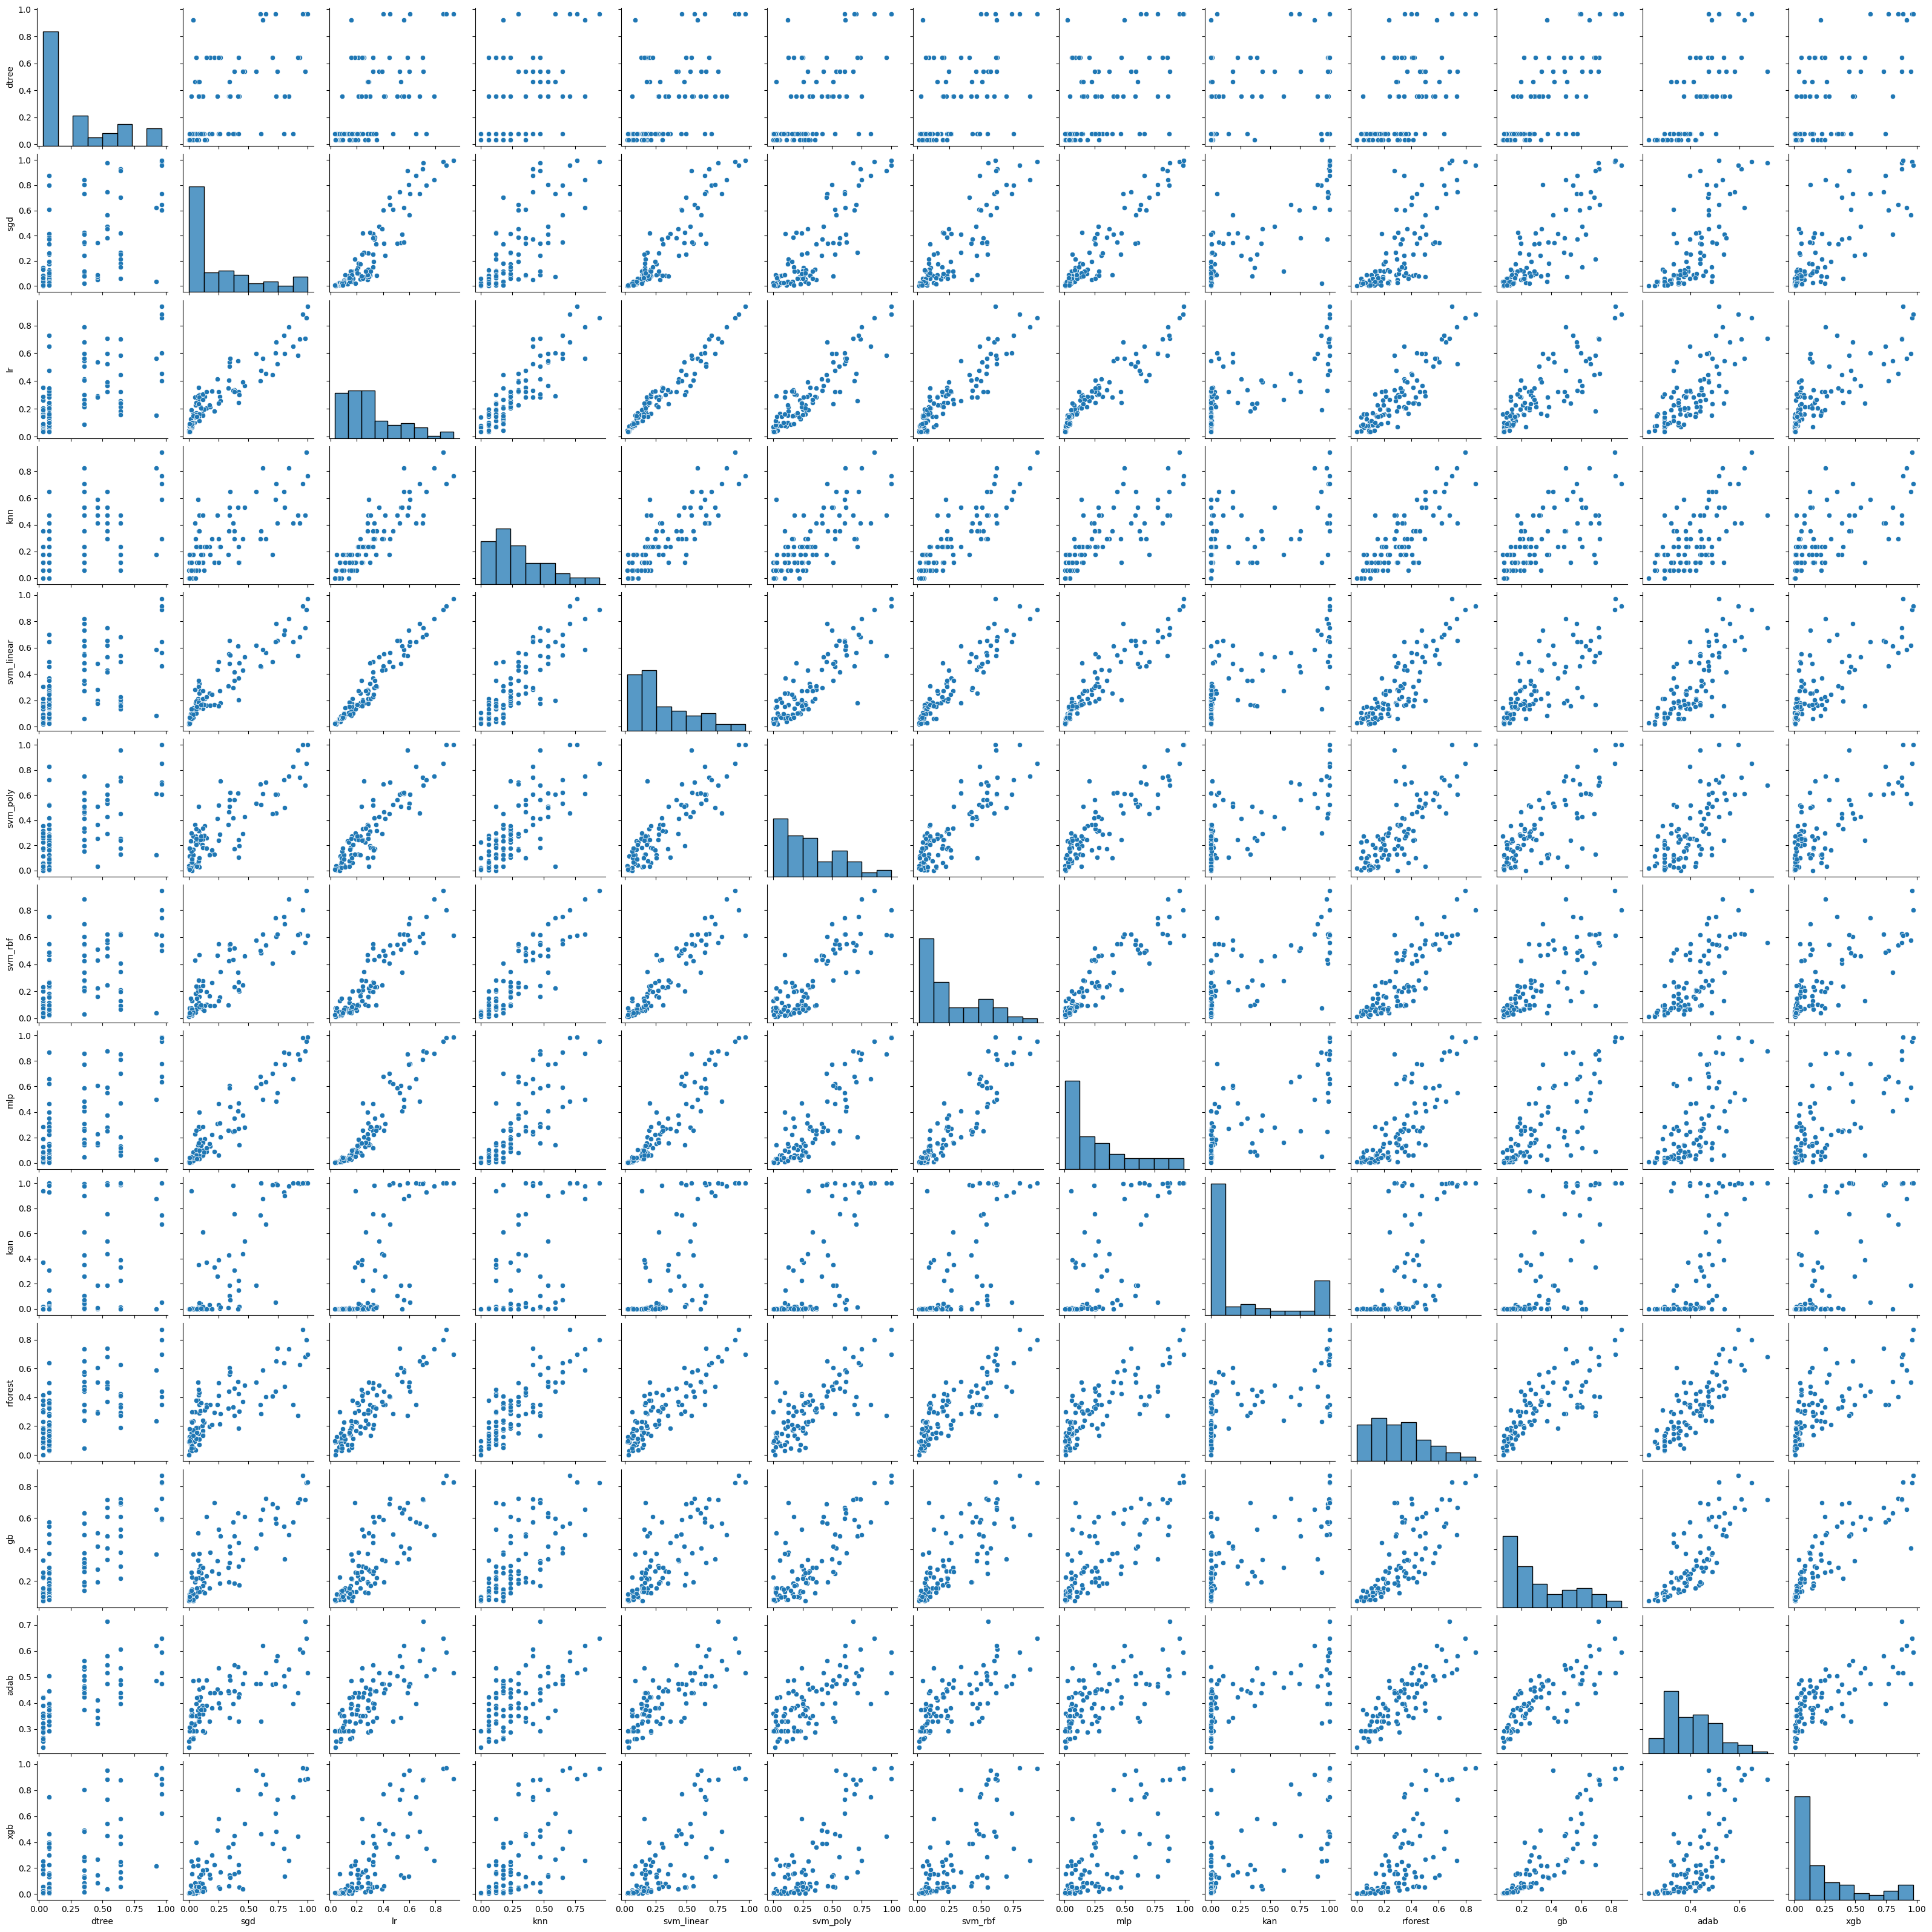

In [45]:
sns.pairplot(models_error)

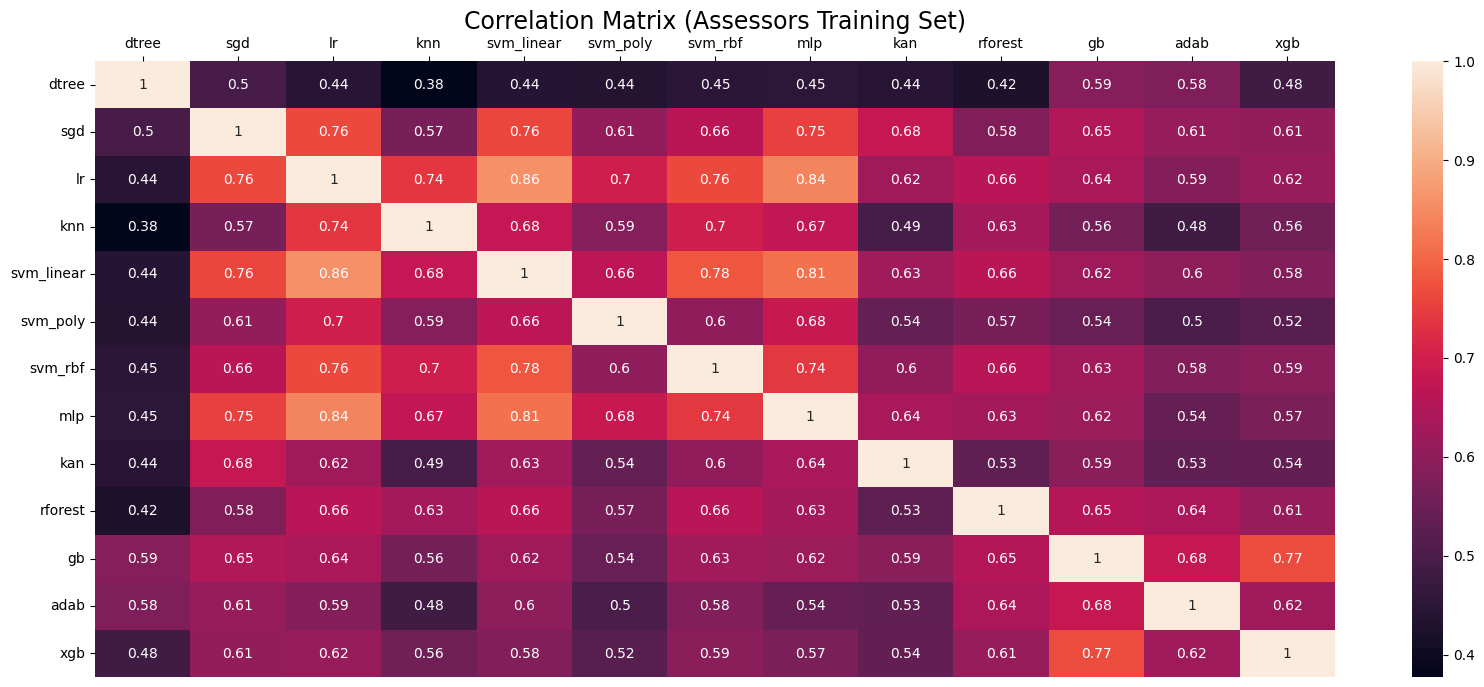

            corr
count  78.000000
mean    0.609434
std     0.100287
min     0.377330
25%     0.546813
50%     0.610750
75%     0.662262
max     0.858455


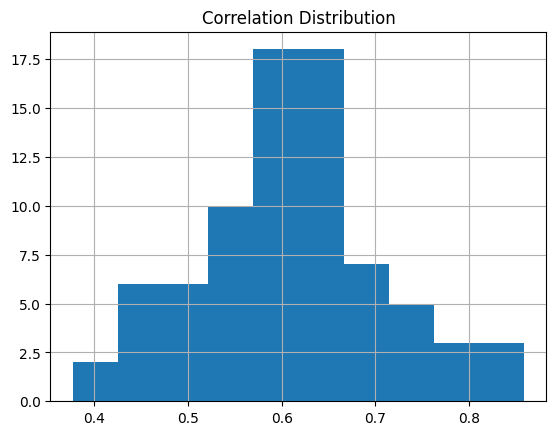

[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [47]:
pred_corrls = models_error.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessors Training Set)', fontsize=17)
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

plt.title('Correlation Distribution')
hg = corrls_values['corr'].hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

kendall:

In [81]:
MIN_SCORE = 0.725 #corrls_values['corr'].quantile(0.85)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.725


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['svm_poly'],
 ['kan'],
 ['rforest'],
 ['gb', 'xgb'],
 ['adab']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [58]:
model_names = list(performs.keys())

Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.357143  0.240465  0.416048  0.470588    0.434321  0.412274  0.464318   
1  0.965517  0.646876  0.452941  0.294118    0.563983  0.699817  0.540896   
2  0.357143  0.733488  0.680125  0.705882    0.781501  0.454220  0.602347   
3  0.461538  0.050179  0.282246  0.411765    0.283095  0.363057  0.428255   
4  0.078947  0.607804  0.476185  0.352941    0.456514  0.520778  0.484935   

        mlp       kan   rforest        gb      adab       xgb  
0  0.306677  0.257097  0.347436  0.327406  0.453882  0.491934  
1  0.632825  0.674116  0.401496  0.724044  0.515561  0.846597  
2  0.485079  0.994194  0.652796  0.568036  0.561110  0.480499  
3  0.226214  0.000329  0.297672  0.193701  0.320892  0.085934  
4  0.622468  0.999975  0.287918  0.496492  0.330144  0.461939

In [59]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.034483  0.113134  0.205486  0.176471    0.147096  0.283670  0.074810   
1  0.034483  0.076642  0.172552  0.176471    0.186982  0.183808  0.101105   
2  0.921053  0.799683  0.663781  0.764706    0.714991  0.651247  0.874132   
3  0.921053  0.730773  0.514733  0.529412    0.500000  0.547081  0.493951   
4  0.461538  0.382534  0.572602  0.705882    0.445445  0.395322  0.513044   

        mlp       kan   rforest        gb      adab       xgb  
0  0.070668  0.000156  0.160674  0.151149  0.419960  0.028248  
1  0.082249  0.000785  0.226245  0.138091  0.261789  0.028824  
2  0.740503  0.997724  0.731392  0.794905  0.669856  0.924587  
3  0.571163  0.999630  0.652502  0.752282  0.580379  0.899618  
4  0.476932  0.883124  0.733779  0.602173  0.453933  0.751114

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

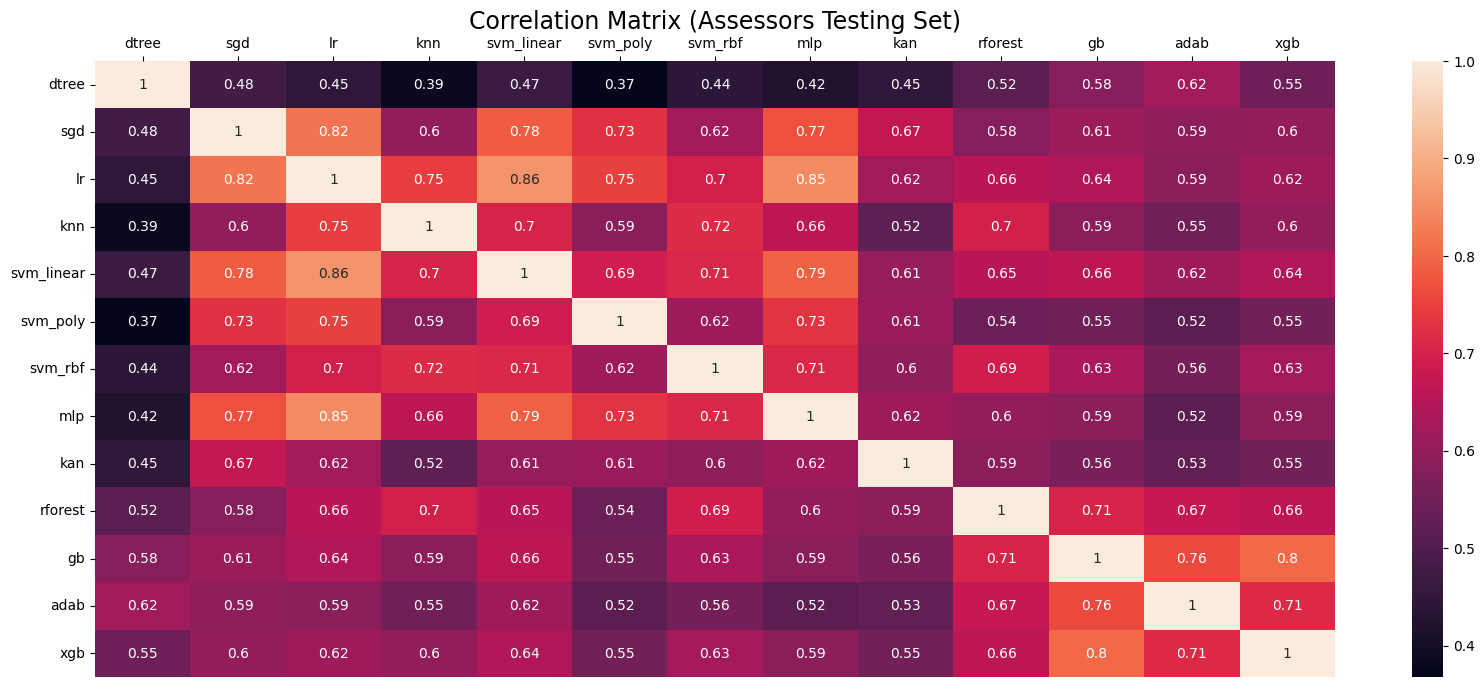

count    78.000000
mean      0.622397
std       0.102396
min       0.367693
25%       0.557593
50%       0.616455
75%       0.694703
max       0.860494
Name: corr, dtype: float64


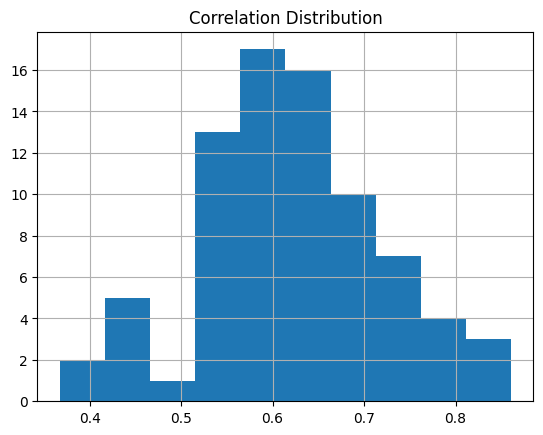

[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [60]:
pred_corrls2 = ya_test.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessors Testing Set)', fontsize=17)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

plt.title('Correlation Distribution')
hg = corrls_values2.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

In [82]:
#MIN_SCORE2 = corrls_values2.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

Min_score: 0.725


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'mlp', 'sgd', 'svm_poly'],
 ['knn', 'lr'],
 ['svm_rbf'],
 ['kan'],
 ['rforest'],
 ['adab', 'gb'],
 ['gb', 'xgb']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0015
NMSE: 0.0389
MAE: 0.0299
NMSE: 0.1508


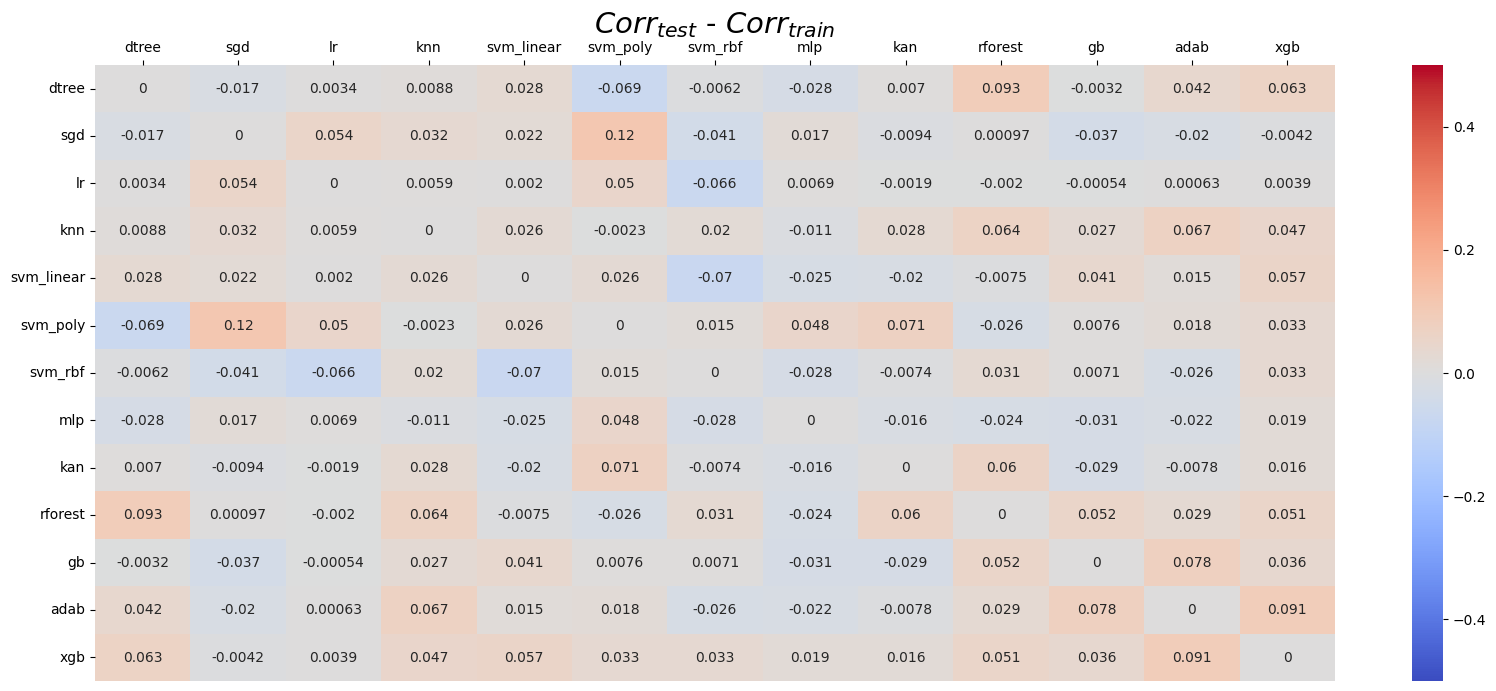

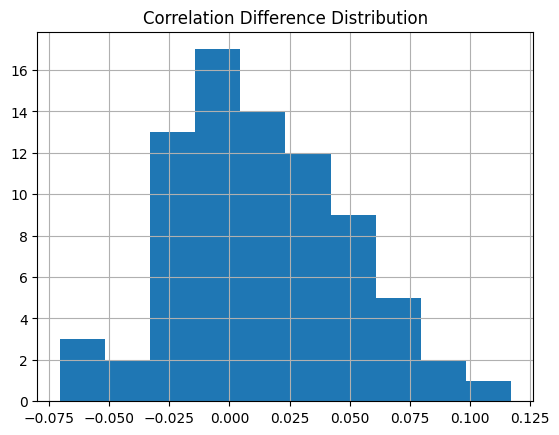

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [83]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = pred_corrls2-pred_corrls
# não adicionar isso em um eventual dataframe de métricas! 
# isso é só para ter uma ideia da diferença das relações de erro 
# conjunto de treinamento e teste. Não tem nada a ver com assessores
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

## Globais

### Regressor Chain
(RC)

In [84]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.1s
[Chain] ................ (12 of 13) Processing order 11, total=   0.1s
[Chain] ................ (13 of 13) Processing order 12, total=   0.1s


In [85]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [86]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0662
RMSE: 0.2493
MAE: 0.1929


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   
multi-output       NaN       NaN       NaN       NaN         NaN       NaN   
individual         NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.056144  0.074294  0.141202  0.039815  0.051366  0.014063   
multi-output       NaN       NaN       NaN       NaN       NaN       NaN   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.105586  
multi-output       NaN  
individual         NaN

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

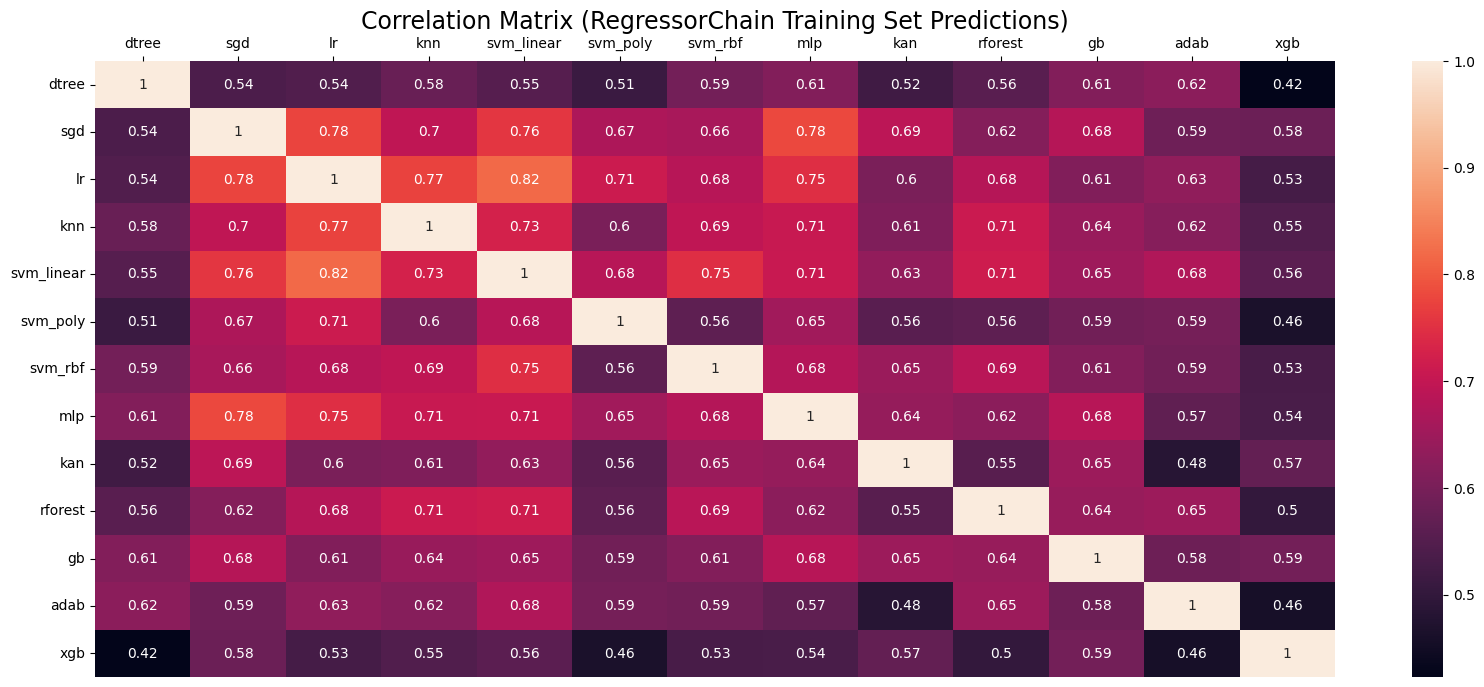

count    78.000000
mean      0.623572
std       0.080524
min       0.422892
25%       0.564502
50%       0.616944
75%       0.682419
max       0.819037
Name: corr, dtype: float64


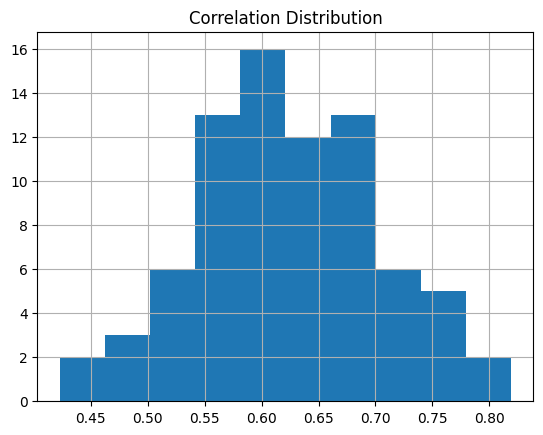

[Saved image "cm_rctrain.eps"]
[Saved image "cd_rctrain.eps"]


In [87]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('kendall') 

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Training Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

In [88]:
#MIN_SCORE3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['regchain_assessor_train'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_train']

Min_score: 0.725


[['dtree'],
 ['lr', 'sgd', 'svm_linear'],
 ['lr', 'mlp', 'sgd'],
 ['knn', 'lr', 'svm_linear'],
 ['svm_linear', 'svm_rbf'],
 ['svm_poly'],
 ['kan'],
 ['rforest'],
 ['gb'],
 ['adab'],
 ['xgb']]

Conjunto de Teste:

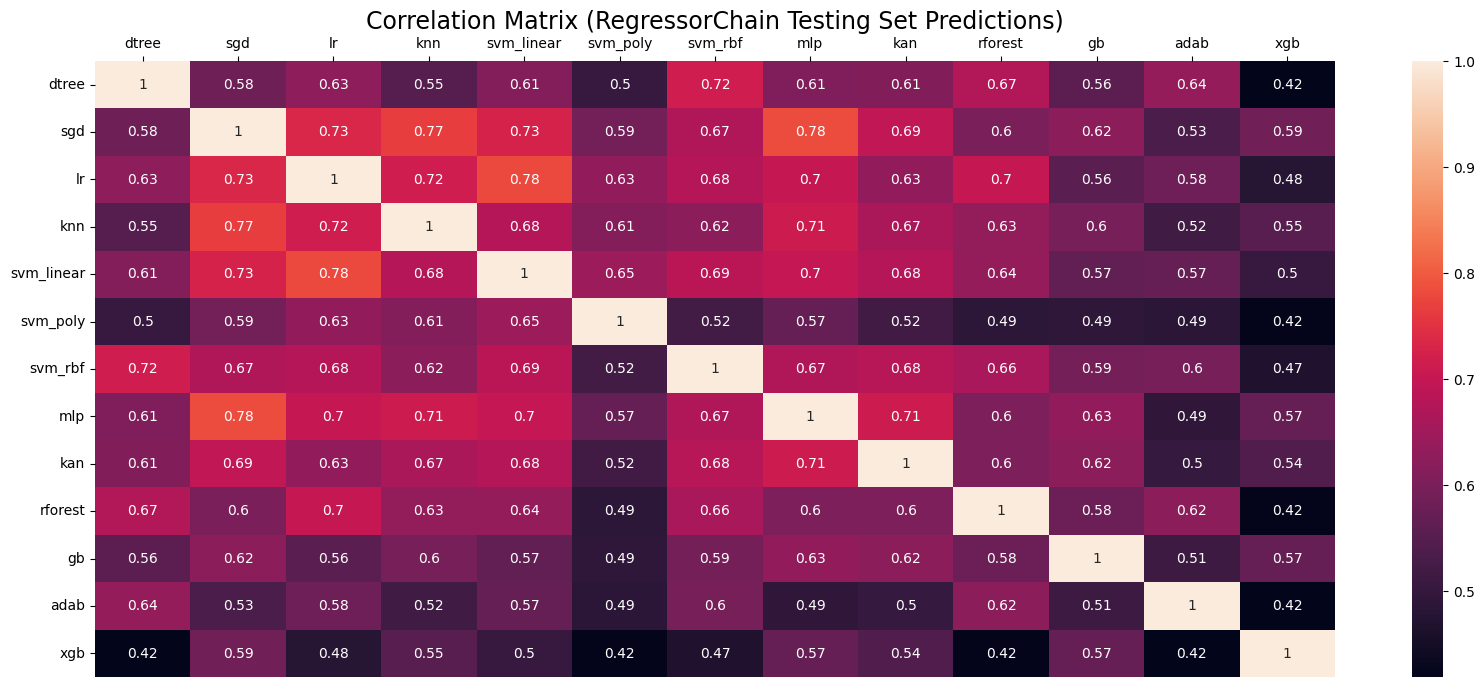

count    78.000000
mean      0.602761
std       0.086044
min       0.419136
25%       0.551474
50%       0.605247
75%       0.670988
max       0.783951
Name: corr, dtype: float64


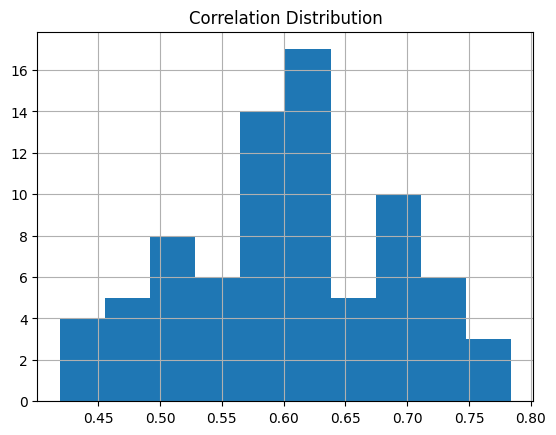

[Saved image "cm_rctest.eps"]
[Saved image "cd_rctest.eps"]


In [89]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

In [90]:
#MIN_SCORE3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['regchain_assessor_test'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_test']

Min_score: 0.725


[['dtree'],
 ['lr', 'sgd', 'svm_linear'],
 ['knn', 'sgd'],
 ['mlp', 'sgd'],
 ['svm_poly'],
 ['svm_rbf'],
 ['kan'],
 ['rforest'],
 ['gb'],
 ['adab'],
 ['xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0116
NMSE: 0.1078
MAE: 0.0833
NMSE: 1.1078
Desvio Padrão: 0.1067


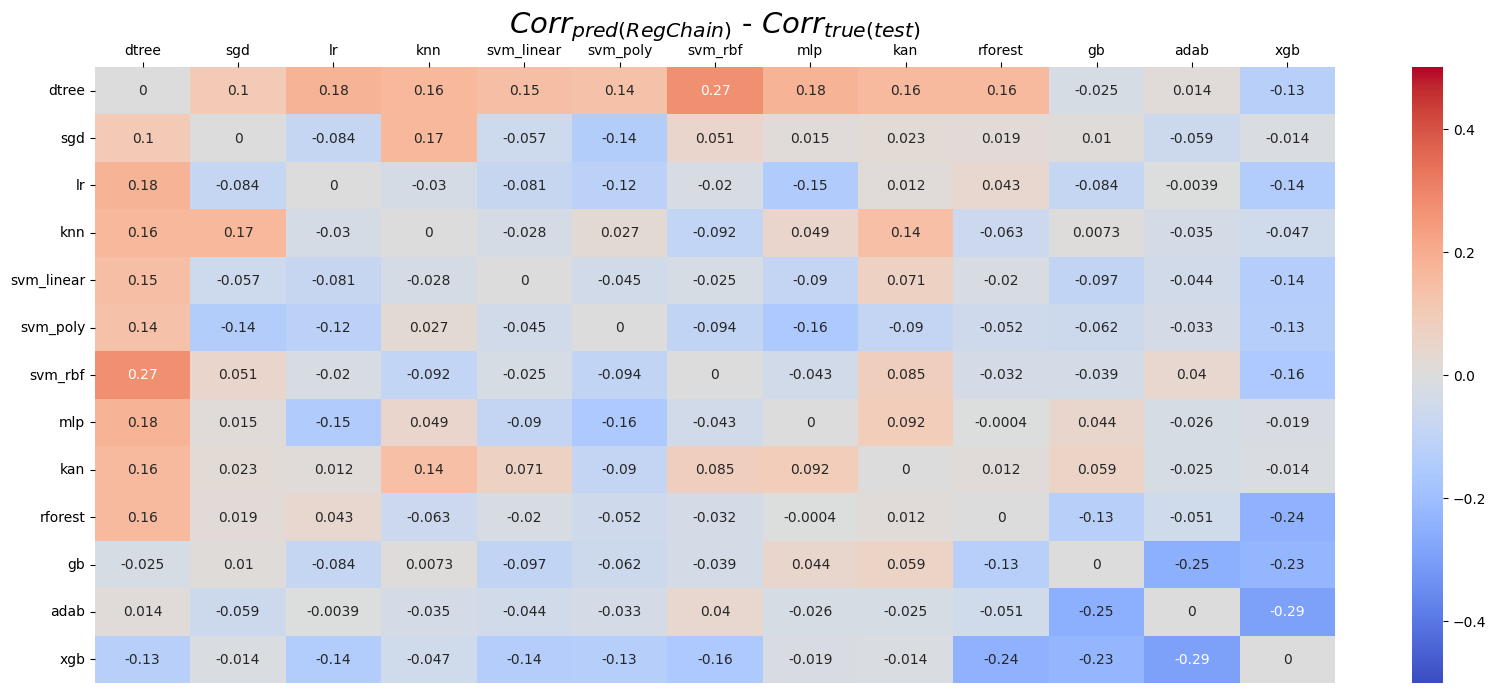

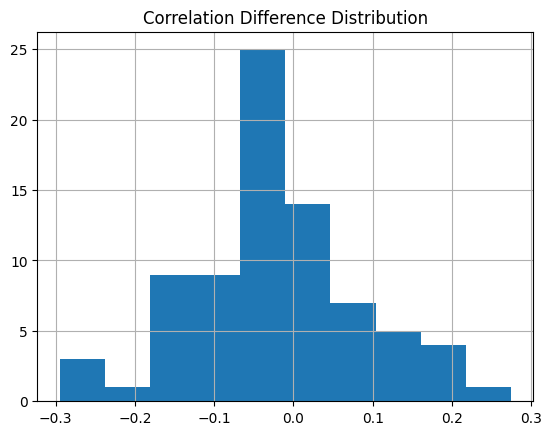

[Saved image "cmd_rc.eps"]
[Saved image "cdd_rc.eps"]


In [99]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChain)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

### Multi-Output Random Forest Regressor 

In [ ]:
mrf = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train)

In [ ]:
ya_pred = mrf.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-rforest',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-rforest',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-rforest',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-rforest',:] = mae_models(ya_test, ya_pred)
mse_df

#### Análise das correlações

Conjunto de Treinamento:

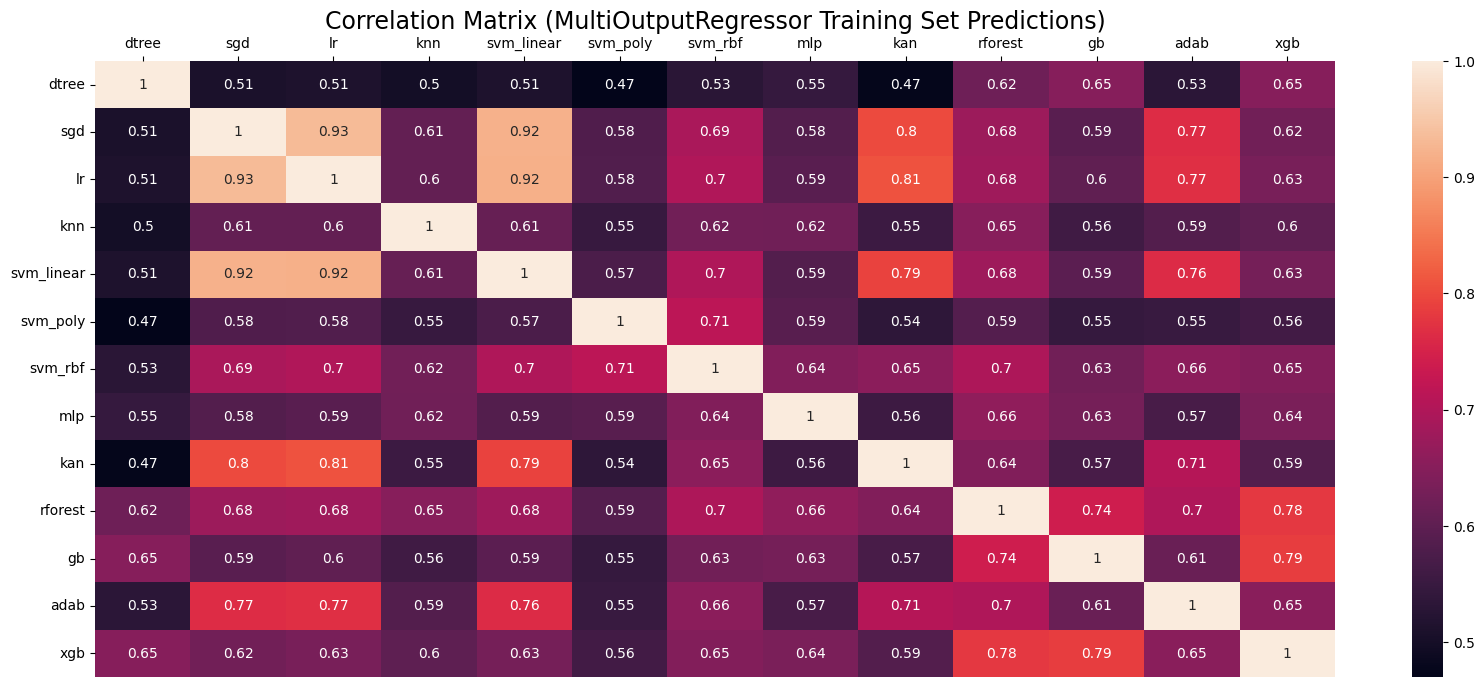

count    78.000000
mean      0.636948
std       0.097030
min       0.470079
25%       0.575778
50%       0.623564
75%       0.679801
max       0.933086
Name: corr, dtype: float64


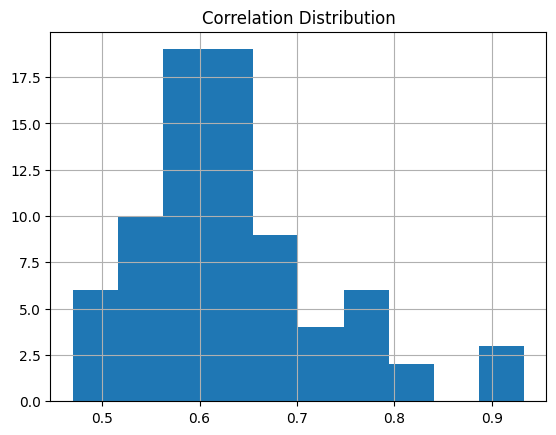

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [ ]:
mrf_corrls = pd.DataFrame(mrf.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

In [ ]:
groups['mrf_assessor_train'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_train']

[['dtree'],
 ['lr', 'rforest', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['adab', 'lr', 'rforest', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

Conjunto de Teste:

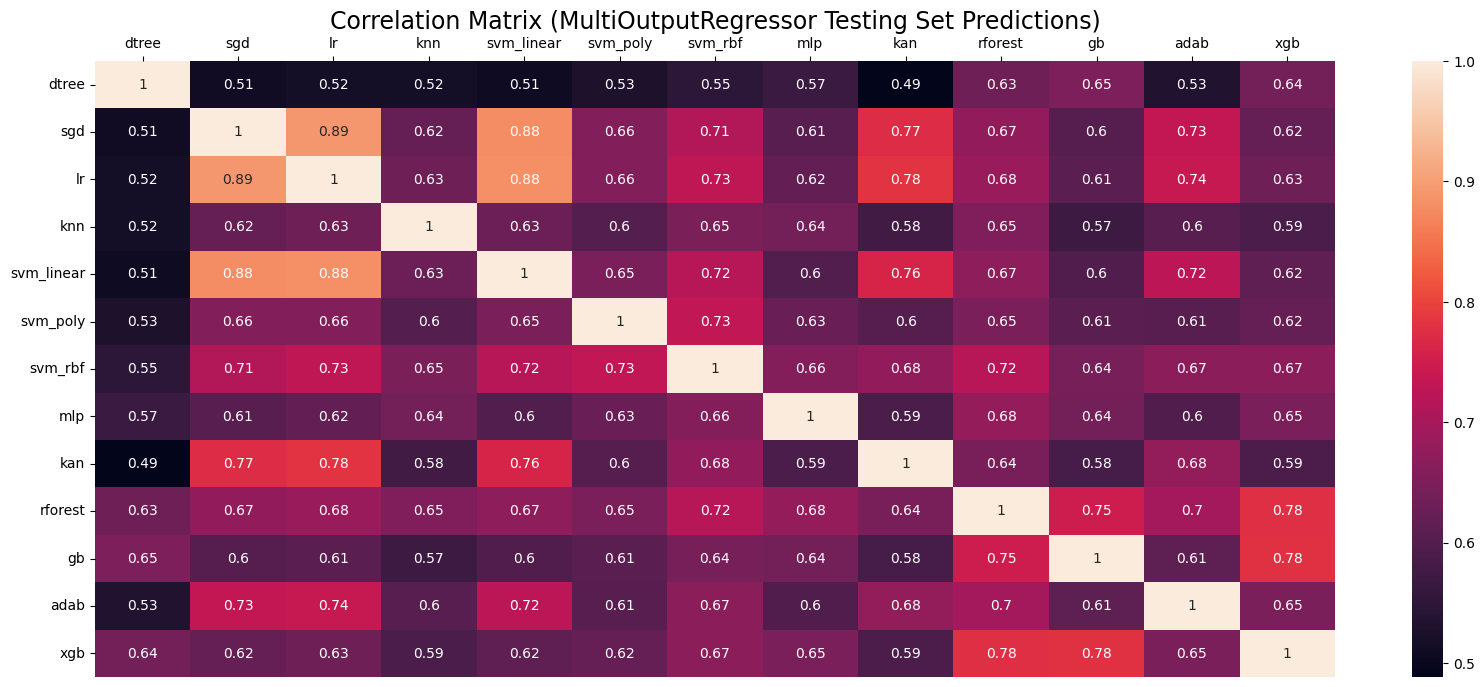

count    78.000000
mean      0.649017
std       0.081683
min       0.488549
25%       0.602560
50%       0.639660
75%       0.678956
max       0.891127
Name: corr, dtype: float64


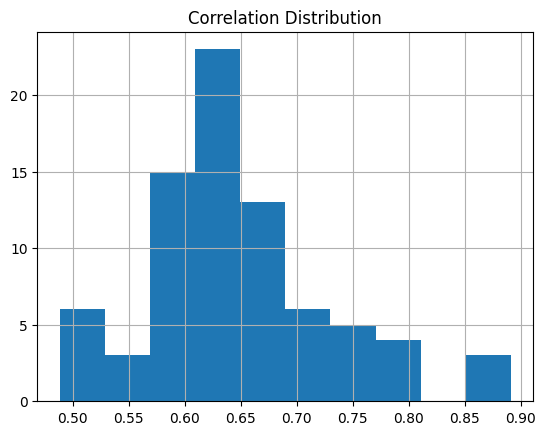

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [ ]:
mrf_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

In [ ]:
groups['mrf_assessor_test'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_test']

[['dtree'],
 ['kan', 'lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'svm_rbf'],
 ['adab', 'lr', 'rforest'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'rforest'],
 ['gb', 'rforest', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0124
RMSE: 0.1116
MAE: 0.0983
NMSE: 0.6700
Desvio Padrão: 0.0634


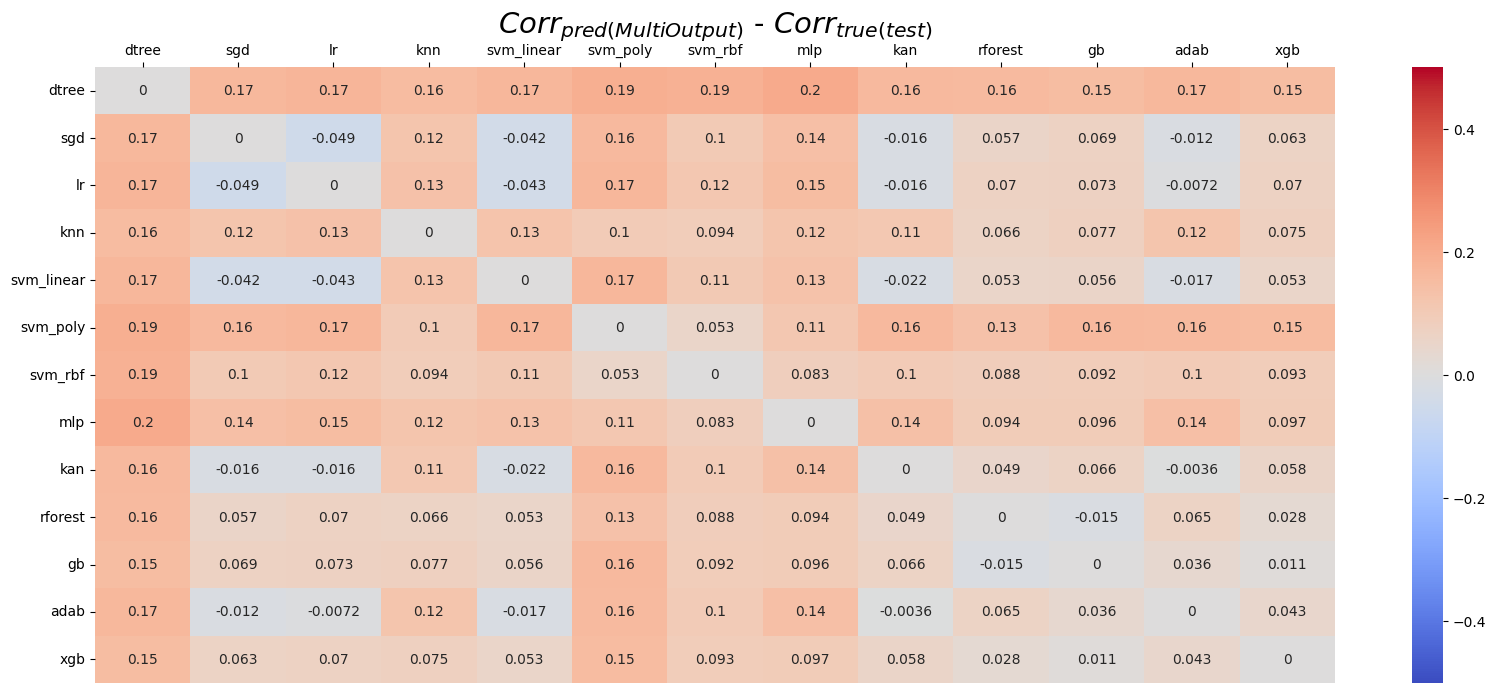

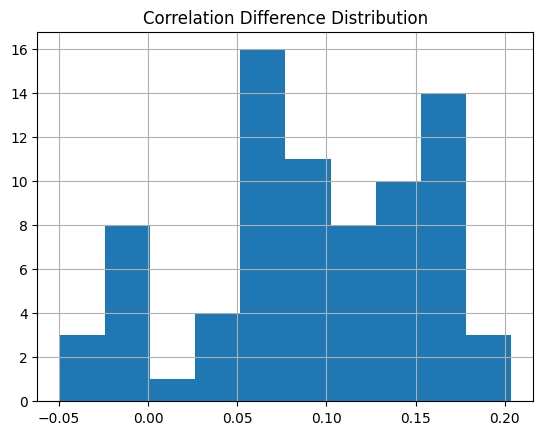

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [ ]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mrf_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandomForest)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

### Multi-Output Regressor 
(ST)

In [92]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [93]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0695
RMSE: 0.2546
MAE: 0.1973


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   
multi-output  0.091869  0.101041  0.046417  0.049038    0.052488  0.048239   
individual         NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.056144  0.074294  0.141202  0.039815  0.051366  0.014063   
multi-output  0.057535  0.077597  0.165216  0.044409  0.053412  0.013986   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.105586  
multi-output  0.101638  
individual         NaN

#### Análise das correlações

Conjunto de Treinamento:

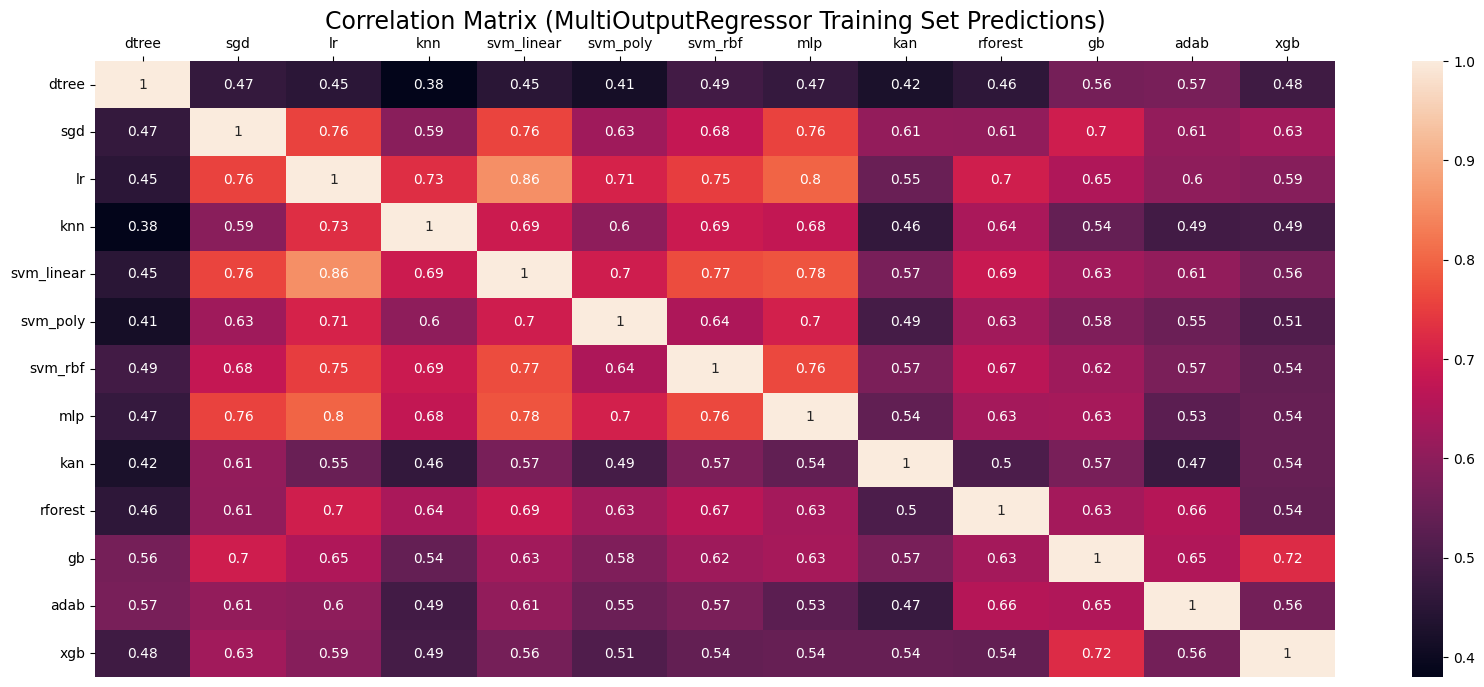

count    78.000000
mean      0.602625
std       0.101848
min       0.379704
25%       0.537850
50%       0.604479
75%       0.678574
max       0.856663
Name: corr, dtype: float64


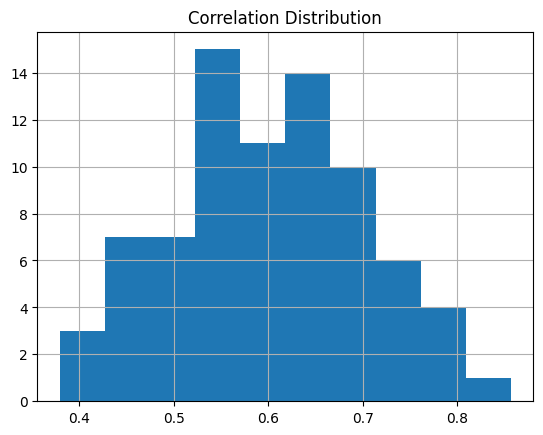

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [94]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

In [95]:
#MIN_SCORE4 = mor_corrls_values.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['mor_assessor_train'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_train']

Min_score: 0.725


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['svm_poly'],
 ['kan'],
 ['rforest'],
 ['gb'],
 ['adab'],
 ['xgb']]

Conjunto de Teste:

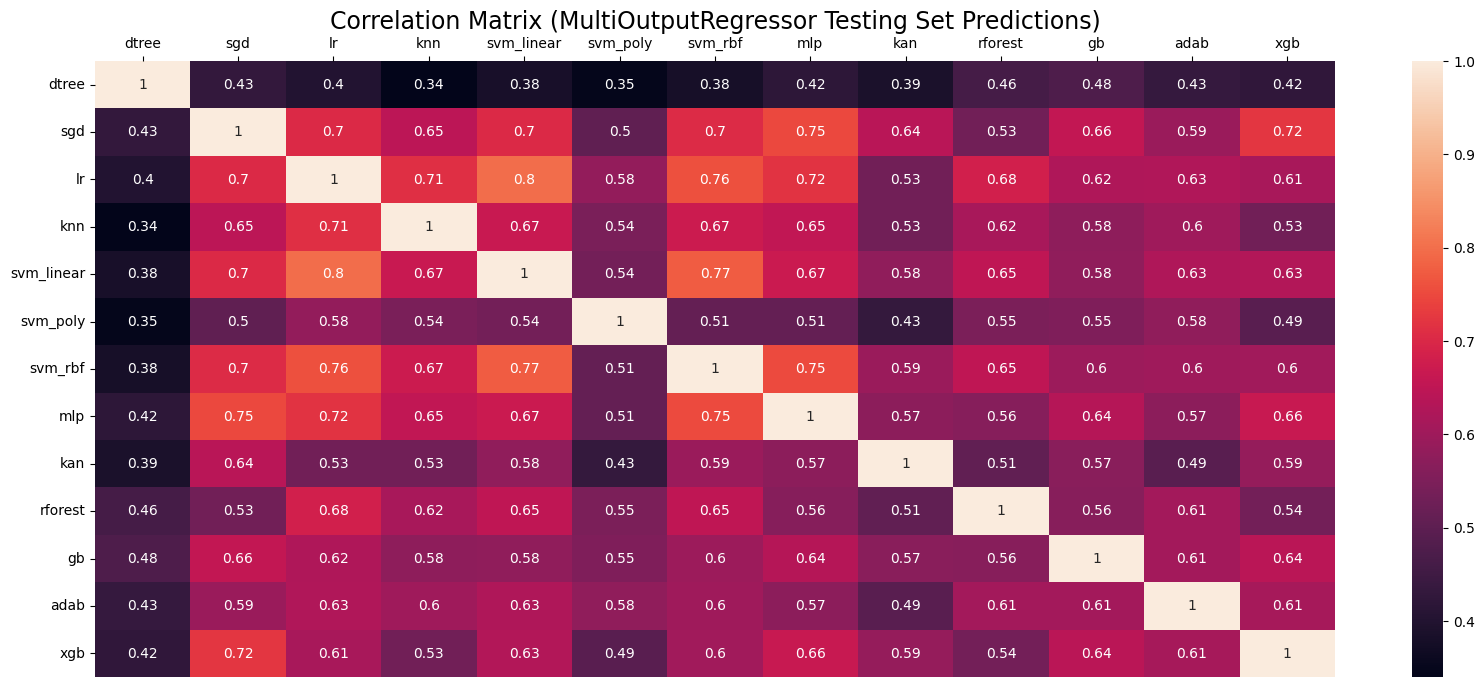

count    78.000000
mean      0.580411
std       0.103503
min       0.339867
25%       0.531481
50%       0.589506
75%       0.650256
max       0.797531
Name: corr, dtype: float64


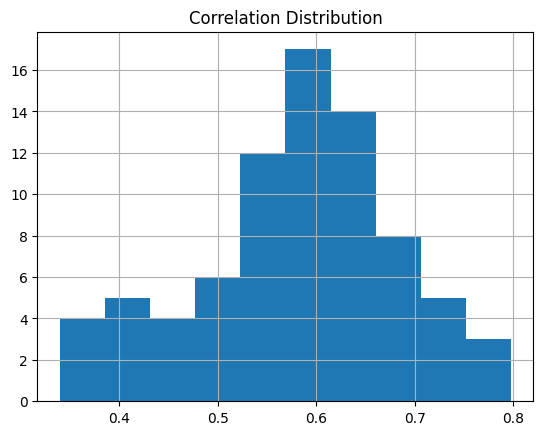

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [96]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

In [97]:
groups['mor_assessor_test'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_test']

[['dtree'],
 ['mlp', 'sgd'],
 ['lr', 'svm_linear', 'svm_rbf'],
 ['knn'],
 ['svm_poly'],
 ['mlp', 'svm_rbf'],
 ['kan'],
 ['rforest'],
 ['gb'],
 ['adab'],
 ['xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0070
RMSE: 0.0838
MAE: 0.0654
NMSE: 0.6693
Desvio Padrão: 0.0730


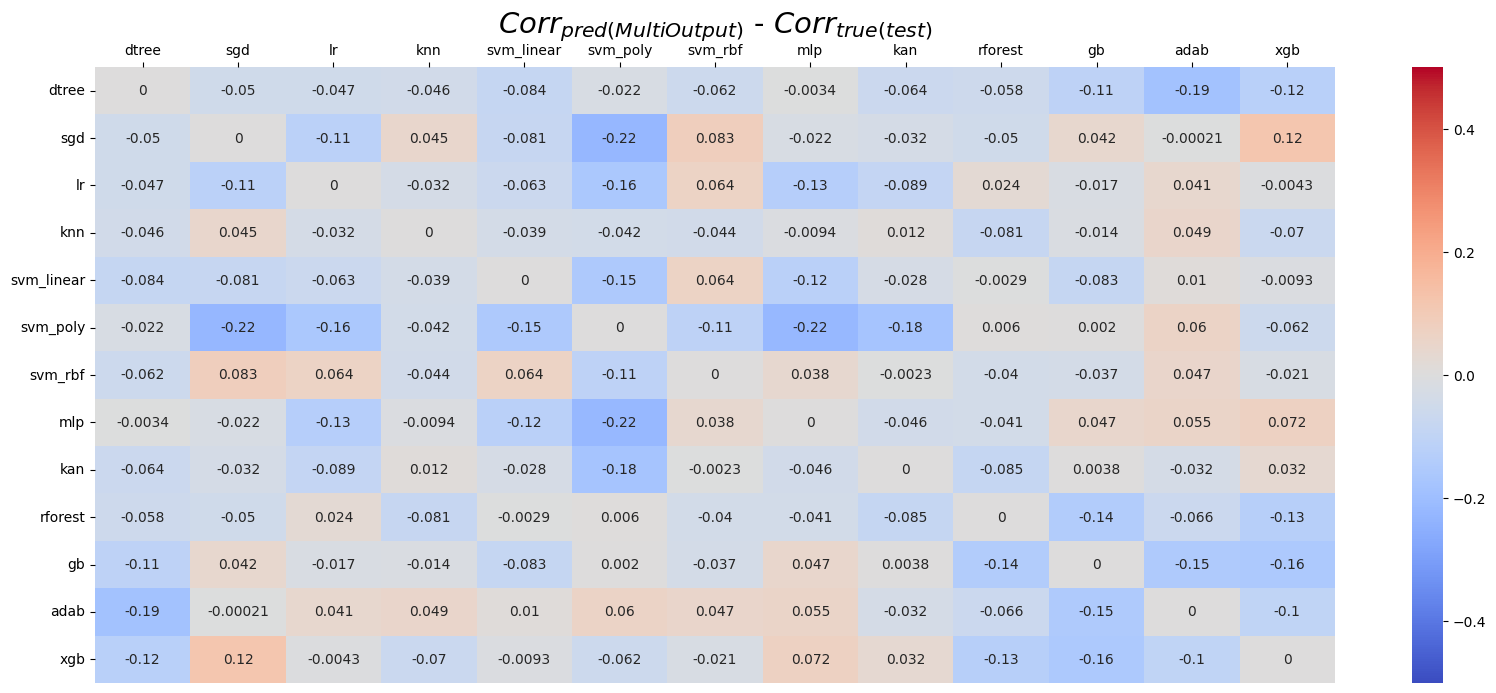

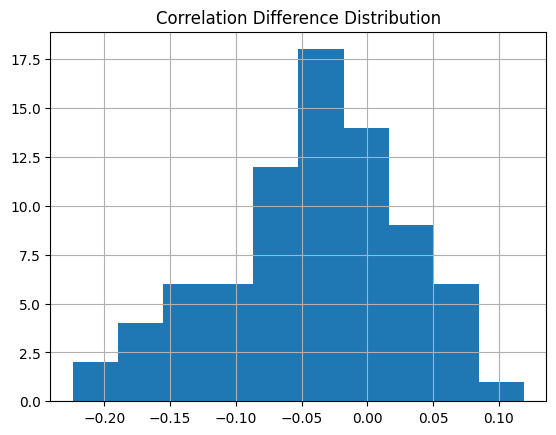

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [100]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mor_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiOutput)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'heart')

## Grupais

In [108]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(9) & true_assessor_test(9):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
['knn', 'lr']
['kan']
['rforest']
['gb', 'xgb']
Número de grupos em comum: 6


true_assessor_train(9) & regchain_assessor_train(11):
['dtree']
['svm_poly']
['kan']
['rforest']
['adab']
Número de grupos em comum: 5


true_assessor_train(9) & regchain_assessor_test(11):
['dtree']
['svm_poly']
['kan']
['rforest']
['adab']
Número de grupos em comum: 5


true_assessor_train(9) & mor_assessor_train(10):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
['knn', 'lr']
['lr', 'mlp', 'svm_linear', 'svm_rbf']
['svm_poly']
['kan']
['rforest']
['adab']
Número de grupos em comum: 8


true_assessor_train(9) & mor_assessor_test(11):
['dtree']
['svm_poly']
['kan']
['rforest']
['adab']
Número de grupos em comum: 5


true_assessor_train(9) & indv_assessor_train(10):
['dtree']
['knn', 'lr']
['lr', 'mlp', 'svm_linear', 'svm_rbf']
['svm_poly']
['kan']
['rforest']
['adab']
Número de grupos em comum: 7


true_assessor_trai

In [109]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['lr', 'mlp', 'sgd', 'svm_linear']
total: 0.7982829413960432

['knn', 'lr']
total: 0.7392848039040564

['lr', 'mlp', 'svm_linear', 'svm_rbf']
total: 0.7994774169466218

['gb', 'xgb']
total: 0.7666945943304602



In [110]:
groups

{'true_assessor_train': [['dtree'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['knn', 'lr'],
  ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
  ['svm_poly'],
  ['kan'],
  ['rforest'],
  ['gb', 'xgb'],
  ['adab']],
 'true_assessor_test': [['dtree'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['lr', 'mlp', 'sgd', 'svm_poly'],
  ['knn', 'lr'],
  ['svm_rbf'],
  ['kan'],
  ['rforest'],
  ['adab', 'gb'],
  ['gb', 'xgb']],
 'regchain_assessor_train': [['dtree'],
  ['lr', 'sgd', 'svm_linear'],
  ['lr', 'mlp', 'sgd'],
  ['knn', 'lr', 'svm_linear'],
  ['svm_linear', 'svm_rbf'],
  ['svm_poly'],
  ['kan'],
  ['rforest'],
  ['gb'],
  ['adab'],
  ['xgb']],
 'regchain_assessor_test': [['dtree'],
  ['lr', 'sgd', 'svm_linear'],
  ['knn', 'sgd'],
  ['mlp', 'sgd'],
  ['svm_poly'],
  ['svm_rbf'],
  ['kan'],
  ['rforest'],
  ['gb'],
  ['adab'],
  ['xgb']],
 'mor_assessor_train': [['dtree'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['knn', 'lr'],
  ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
  ['svm_poly'],
  ['kan'],
  ['r

In [111]:
groups['true_assessor_train']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['svm_poly'],
 ['kan'],
 ['rforest'],
 ['gb', 'xgb'],
 ['adab']]

In [112]:
groups['true_assessor_test']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'mlp', 'sgd', 'svm_poly'],
 ['knn', 'lr'],
 ['svm_rbf'],
 ['kan'],
 ['rforest'],
 ['adab', 'gb'],
 ['gb', 'xgb']]

### Regressor Chain

In [113]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [114]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0680
RMSE: 0.2520
MAE: 0.1961
NMSE: 1.0229


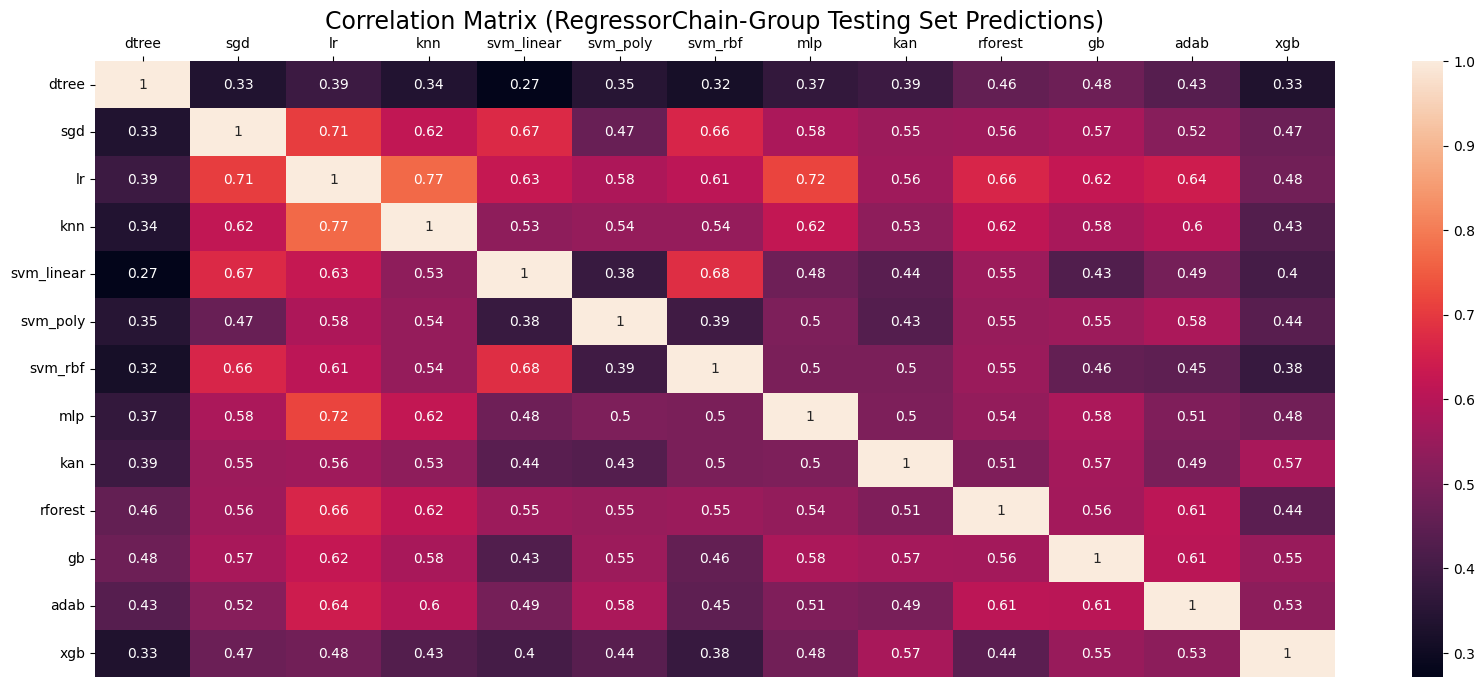

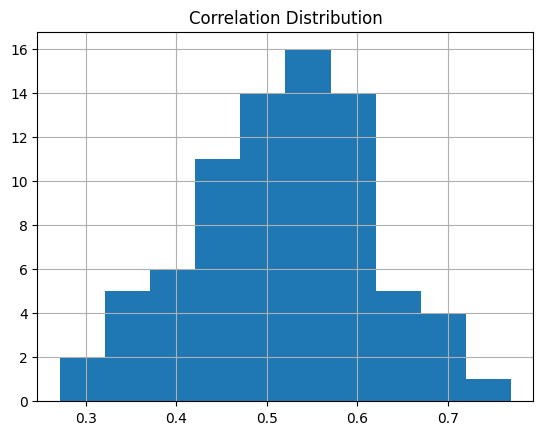

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0193
NMSE: 0.1390
MAE: 0.1134
NMSE: 1.8435
Desvio Padrão: 0.0907


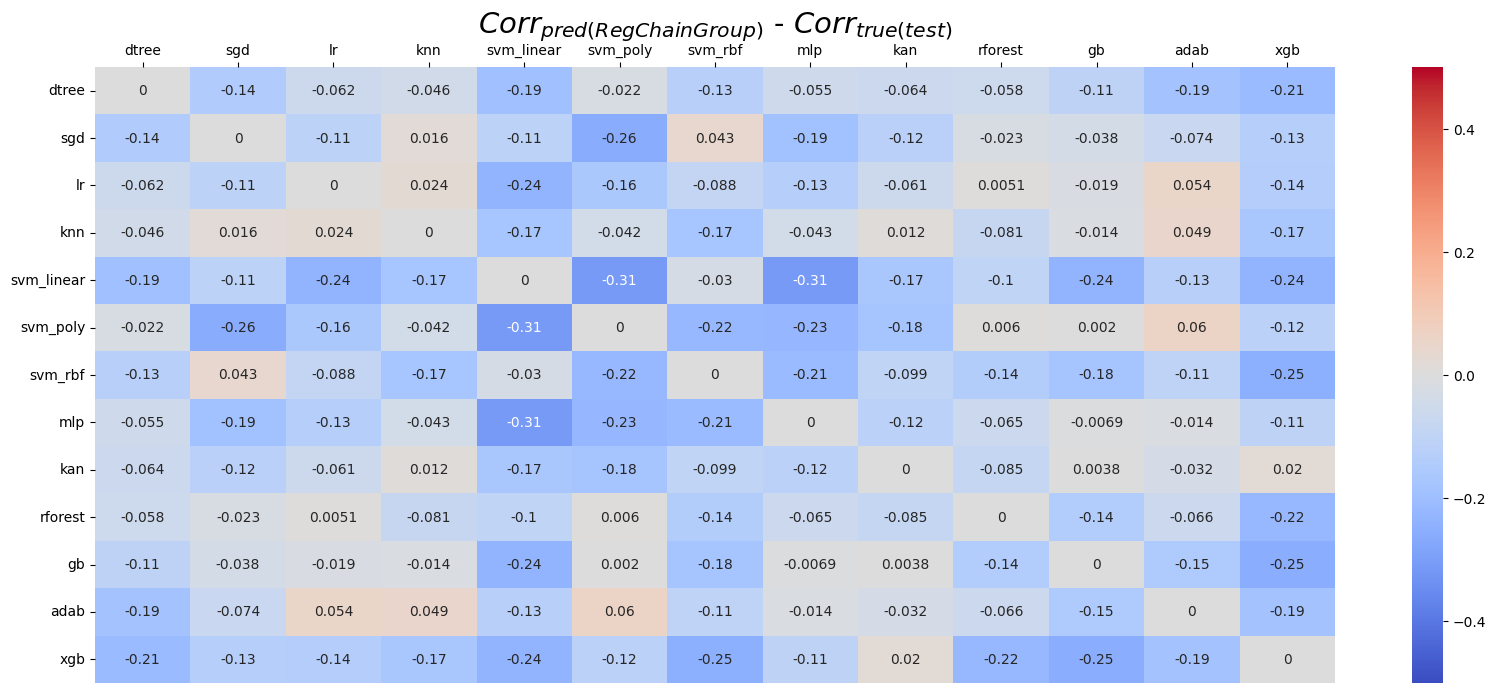

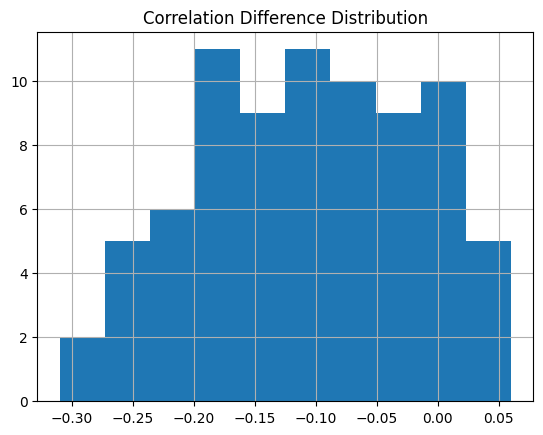

[Saved image "cm_rcgtest.eps"]
[Saved image "cd_rcgtest.eps"]
[Saved image "cmd_rcg.eps"]
[Saved image "cdd_rcg.eps"]


In [115]:
regchainGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['regchain(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['regchain(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['regchain(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(regchainGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(regchainGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChainGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

save2figs(hm1, hg1, 'heart')
save2figs(hm2, hg2, 'heart')

### Multi-Output Regressor

In [ ]:
mrf4groups = []

for g in groups['true_assessor_train']:
    model = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train[g])
    mrf4groups.append(model)

In [ ]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mrf4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0695
RMSE: 0.2546
MAE: 0.1973
NMSE: 1.0450


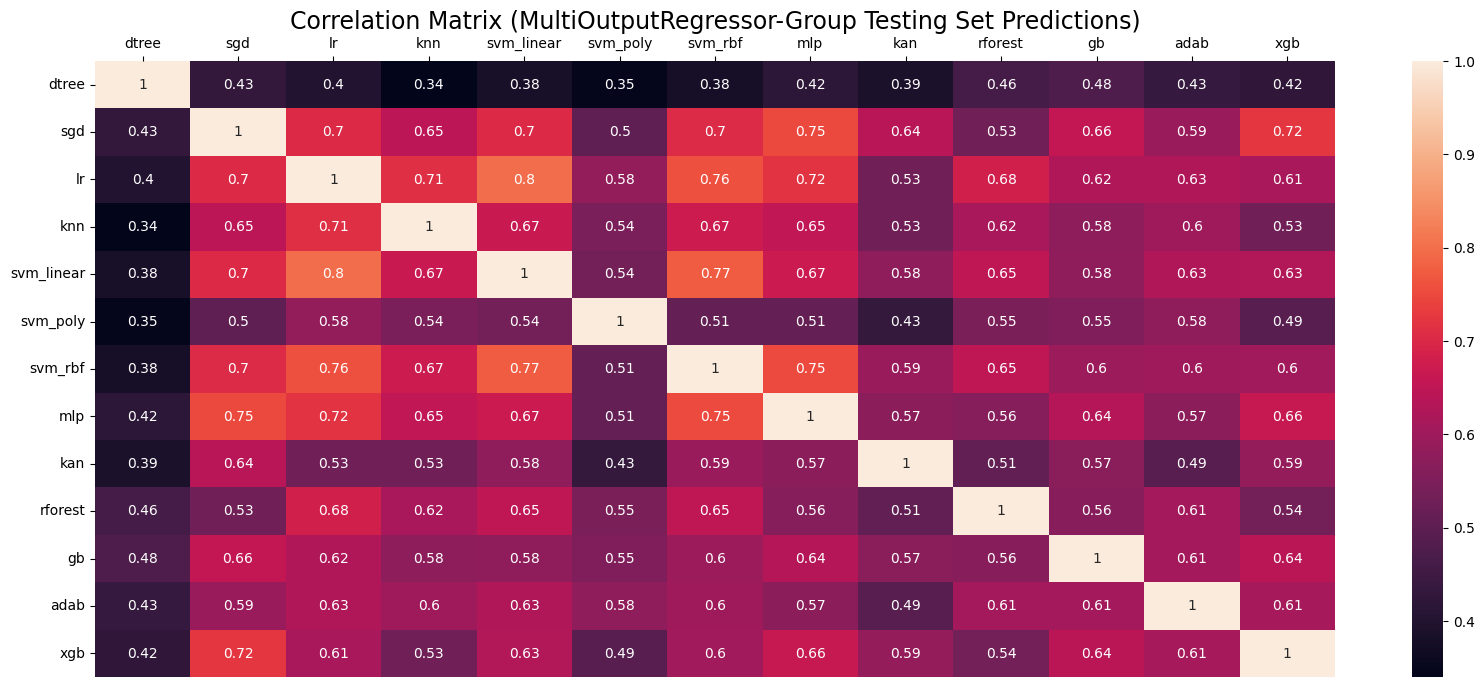

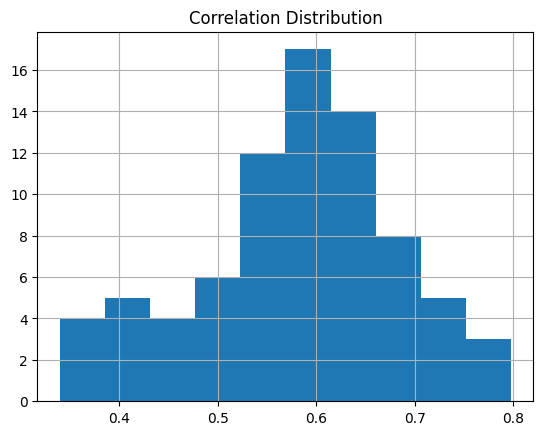

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0070
NMSE: 0.0838
MAE: 0.0654
NMSE: 0.6693
Desvio Padrão: 0.0730


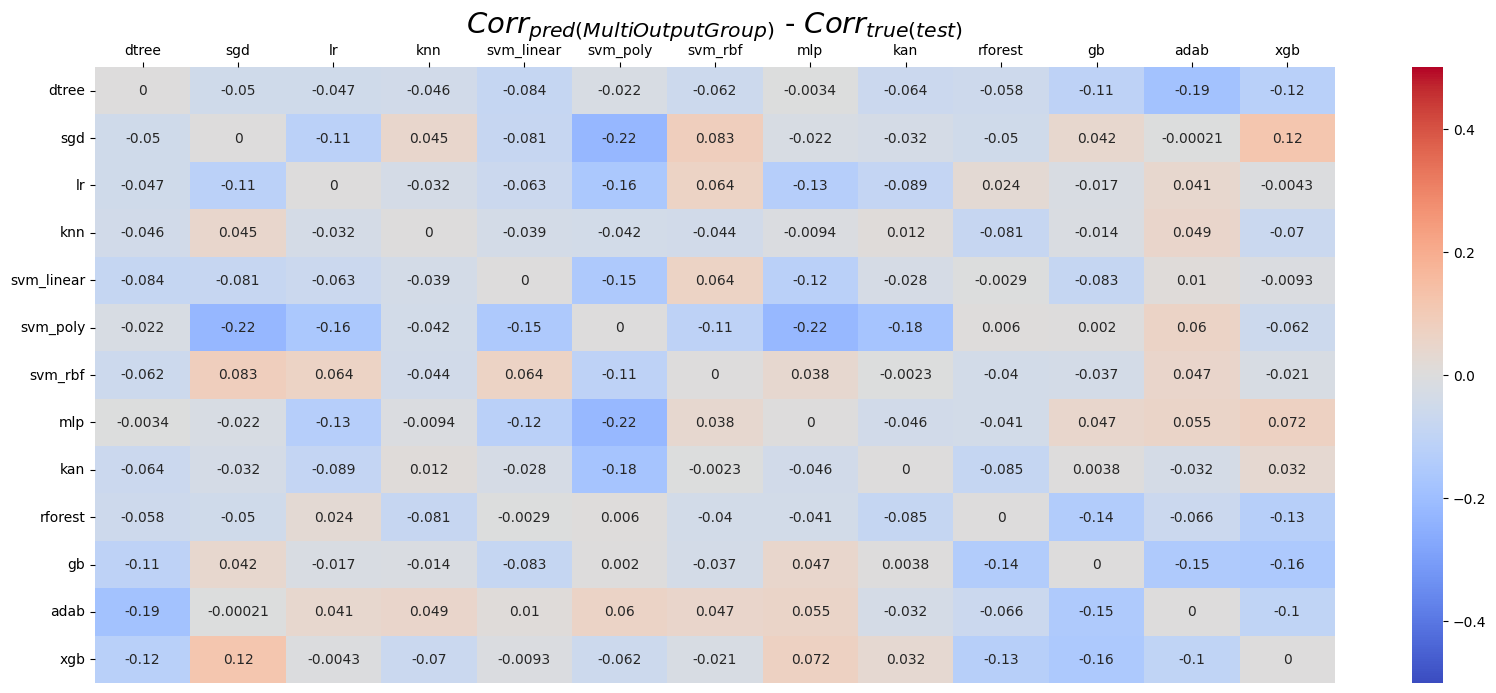

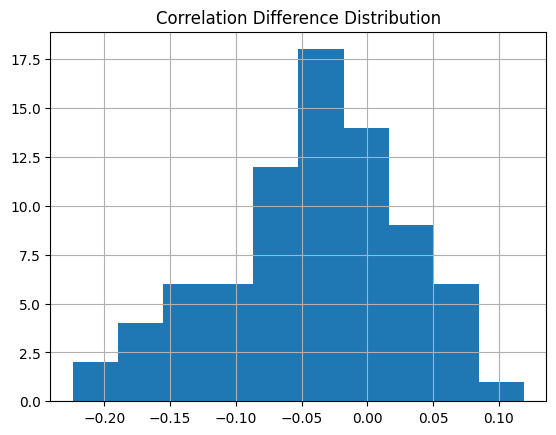

[Saved image "cm_morgtest.eps"]
[Saved image "cd_morgtest.eps"]
[Saved image "cmd_mog.eps"]
[Saved image "cdd_mog.eps"]


In [ ]:
morGroups_corrls = y_pred.corr('kendall')
#pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['multi-rforest(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['multi-rforest(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['multi-rforest(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['multi-rforest(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(morGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm1)

plt.title('Correlation Distribution')
hg1 = corrlArray(morGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = morGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandForestGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

save2figs(hm1, hg1, 'heart')
save2figs(hm2, hg2, 'heart')

In [138]:
yb_test.shape

(95,)

In [144]:
Xb_train.shape

(94, 13)

## Análises

In [125]:
import os

In [ ]:
set_heart = set(os.listdir('data\heart\imgs'))
set_churn = set(os.listdir('data\churn\imgs'))

print(set_heart - set_churn)

{'cm_atrain.eps', 'cd_atrain.eps'}


<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\pedro\AppData\Local\Temp\ipykernel_6768\1191516084.py:1: SyntaxWarning: invalid escape sequence '\h'
  set_heart = set(os.listdir('data\heart\imgs'))
C:\Users\pedro\AppData\Local\Temp\ipykernel_6768\1191516084.py:2: SyntaxWarning: invalid escape sequence '\i'
  set_churn = set(os.listdir('data/churn\imgs'))


In [131]:
set_churn - set_heart

{'cd_rc.eps'}

In [119]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(rmse_df, 'RMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE      RMSE       MAE      NMSE
0              regchain  dtree  0.091869  0.303099  0.227641  0.914335
1          multi-output  dtree  0.091869  0.303099  0.227641  0.914335
2            individual  dtree  0.093350  0.305533  0.231295  0.929076
3       regchain(group)  dtree  0.091869  0.303099  0.227641  0.914335
4   multi-output(group)  dtree  0.091869  0.303099  0.227641  0.914335
..                  ...    ...       ...       ...       ...       ...
60             regchain    xgb  0.105586  0.324940  0.243852  1.131610
61         multi-output    xgb  0.101638  0.318808  0.244208  1.089298
62           individual    xgb  0.086256  0.293694  0.229022  0.924442
63      regchain(group)    xgb  0.101625  0.318786  0.247379  1.089153
64  multi-output(group)    xgb  0.101638  0.318808  0.244208  1.089298

[65 rows x 6 columns]

In [120]:
teste = metrics_df.drop(columns=['model']).groupby(['assessor_type']).agg(['mean', 'std'])
#teste.to_csv('data/heart/results.csv')
teste

MSE                RMSE                 MAE  \
                         mean       std      mean       std      mean   
assessor_type                                                           
individual           0.067220  0.035994  0.251019  0.067528  0.196317   
multi-output         0.069453  0.038255  0.254646  0.070653  0.197251   
multi-output(group)  0.069453  0.038255  0.254646  0.070653  0.197251   
regchain             0.066201  0.033963  0.249287  0.066293  0.192944   
regchain(group)      0.067977  0.037782  0.251963  0.069758  0.196105   

                                   NMSE            
                          std      mean       std  
assessor_type                                      
individual           0.054071  1.020568  0.102351  
multi-output         0.054631  1.044975  0.101072  
multi-output(group)  0.054631  1.044975  0.101072  
regchain             0.052462  1.005892  0.094871  
regchain(group)      0.054792  1.022910  0.078691

In [121]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[-1], sns.color_palette()[1]]

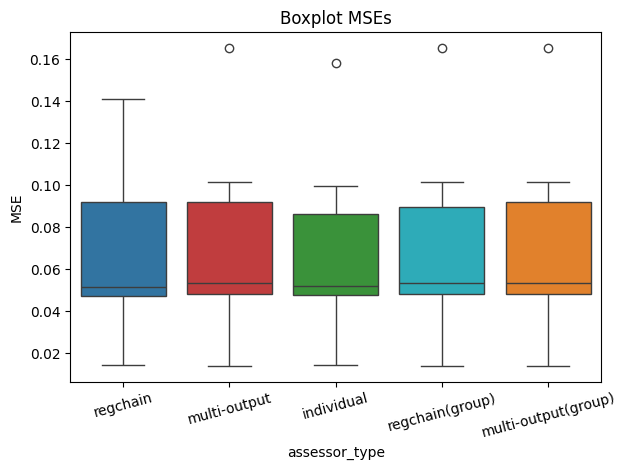

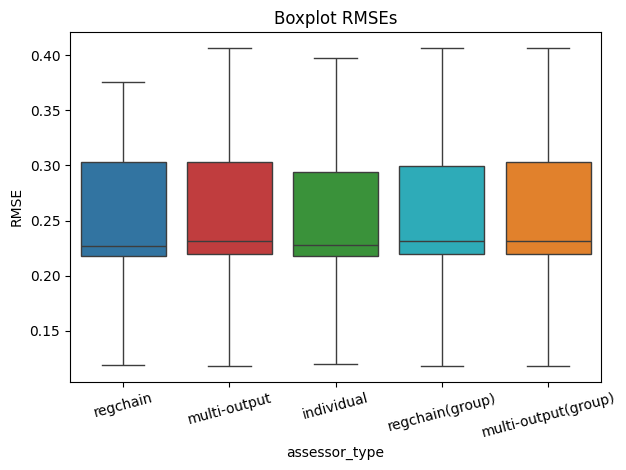

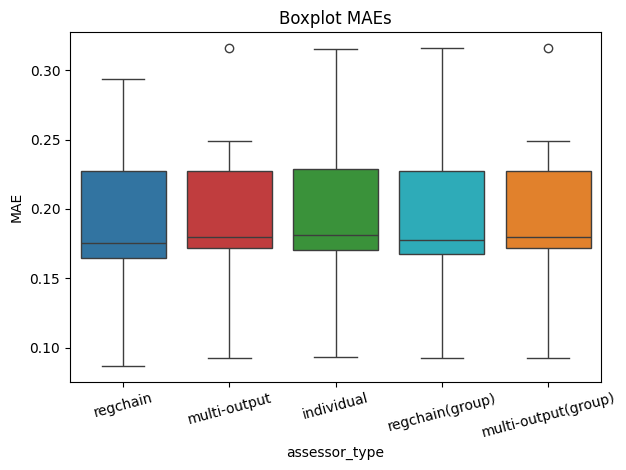

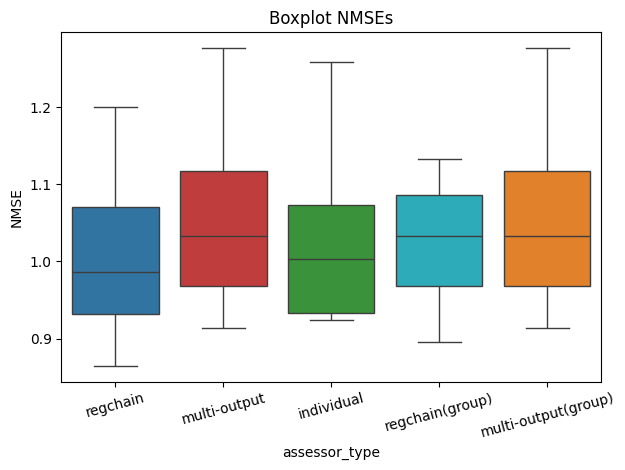

In [122]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.title(f'Boxplot {mt}s')
    imgplt = sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/heart/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

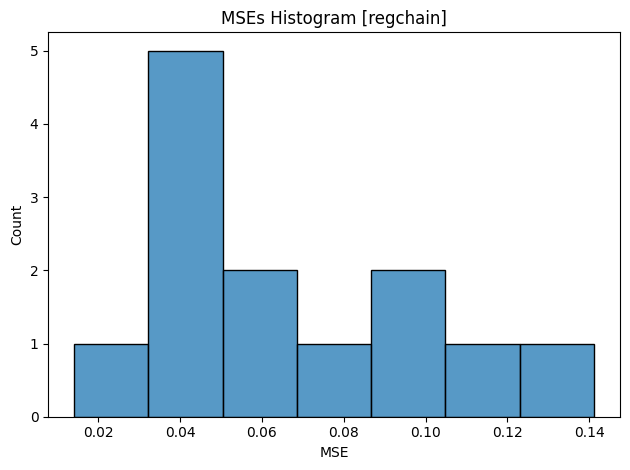

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


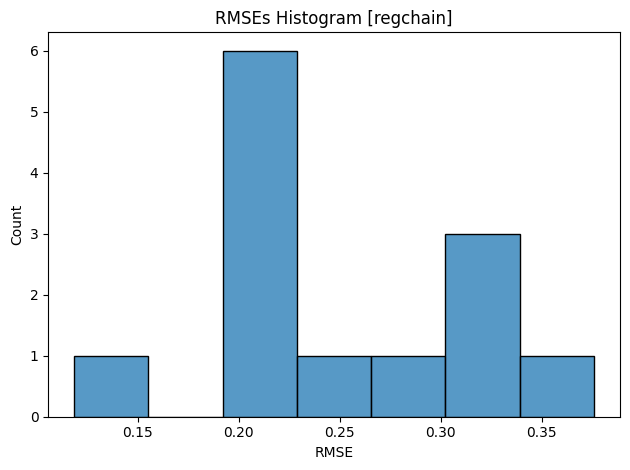

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


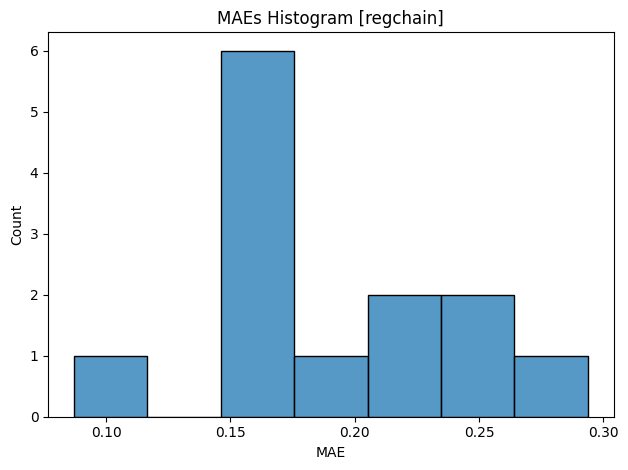

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


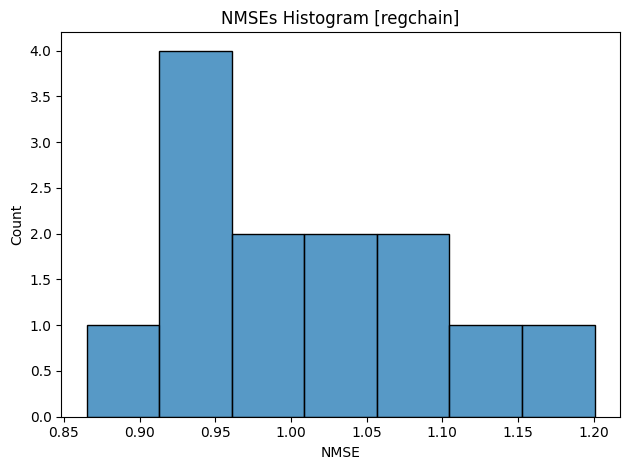

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


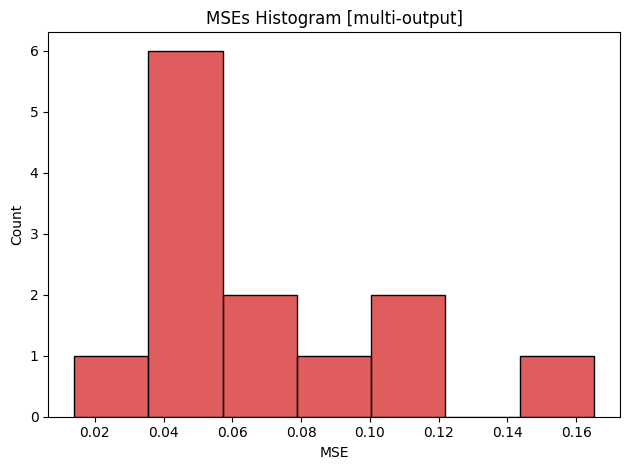

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


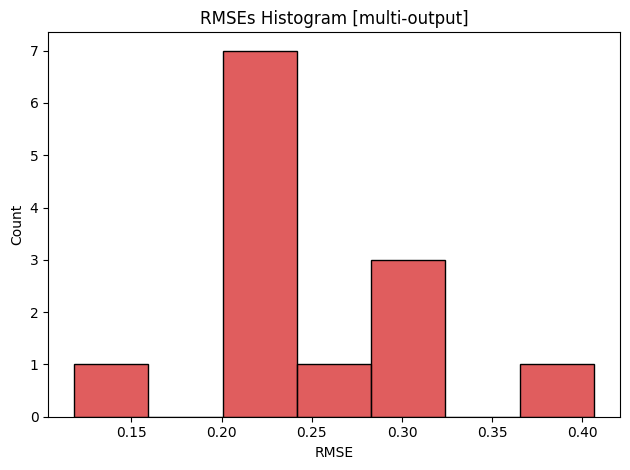

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


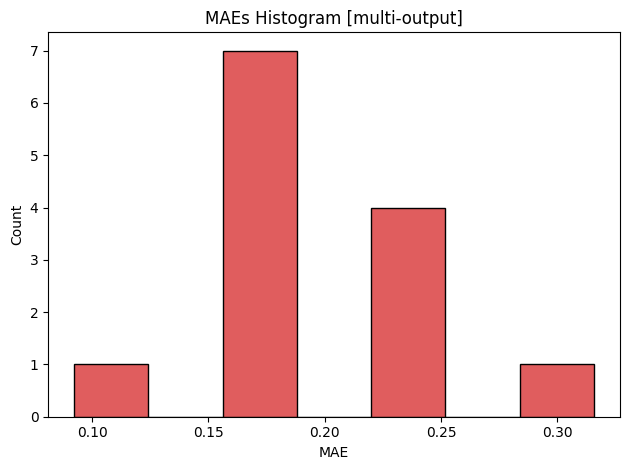

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


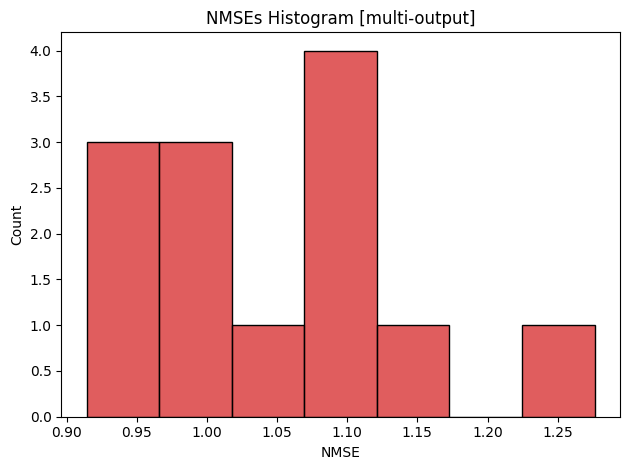

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


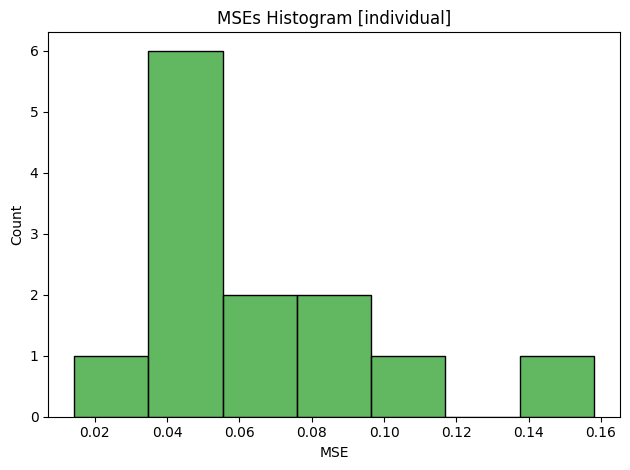

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


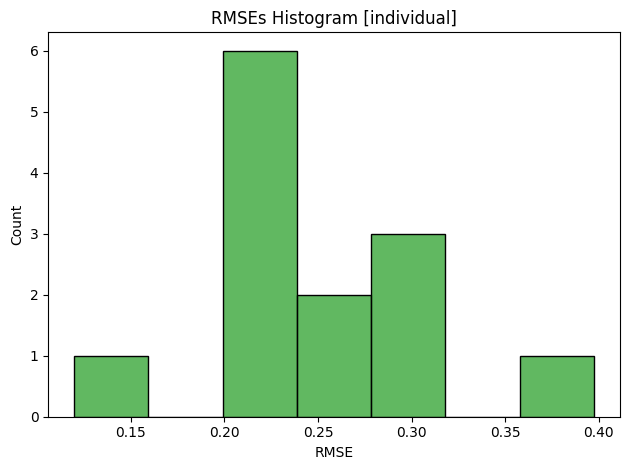

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


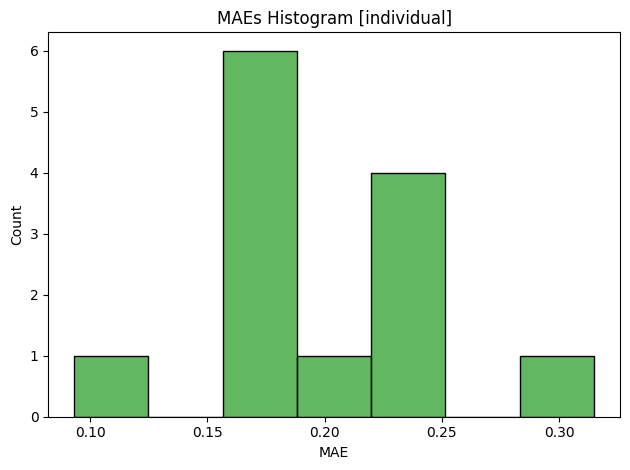

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


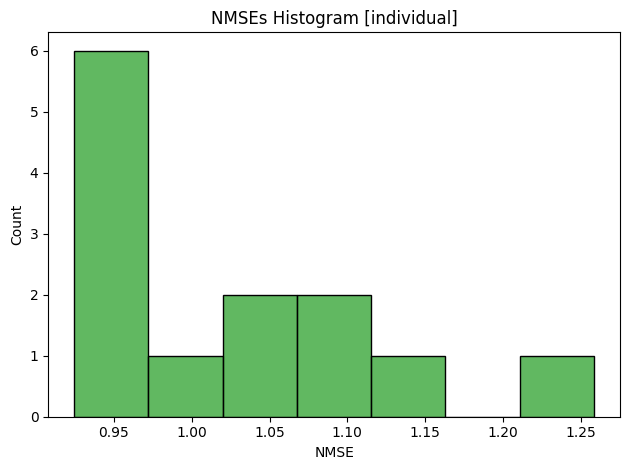

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


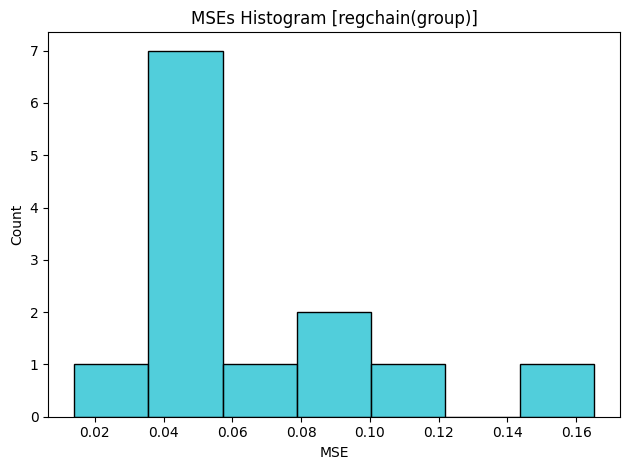

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


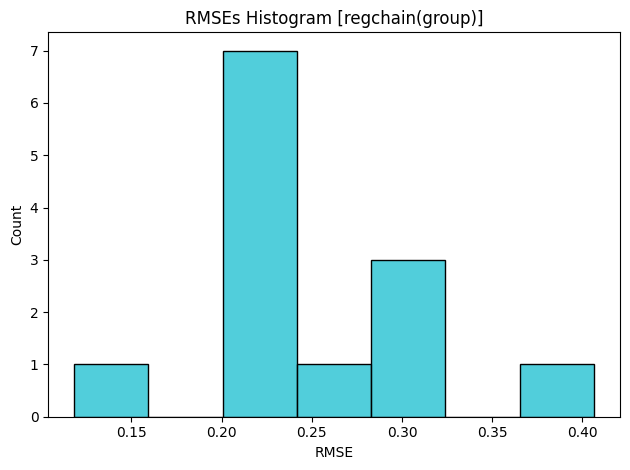

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


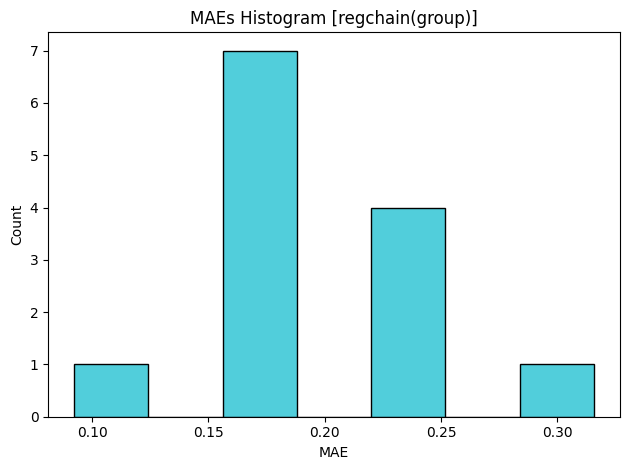

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


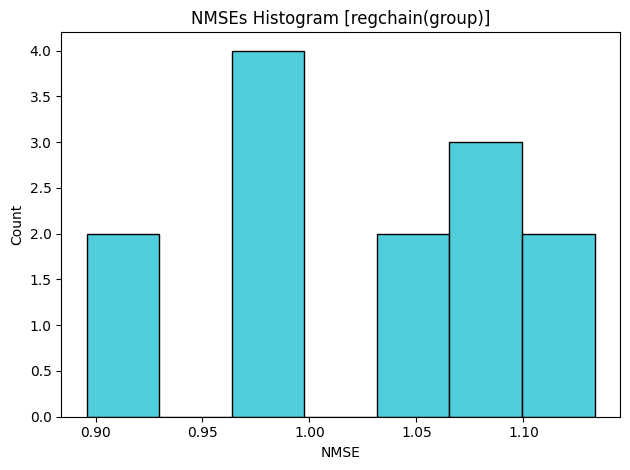

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


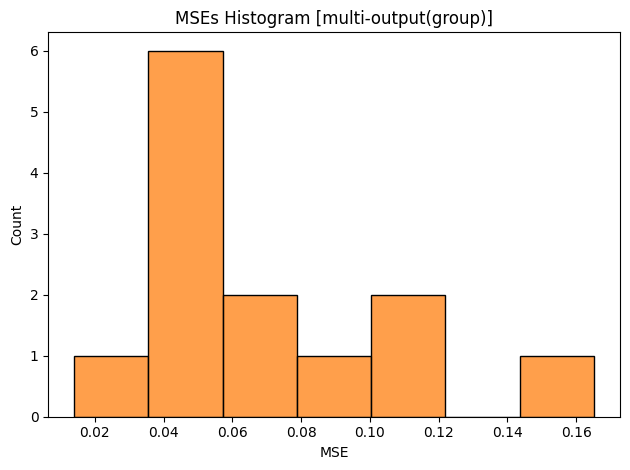

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


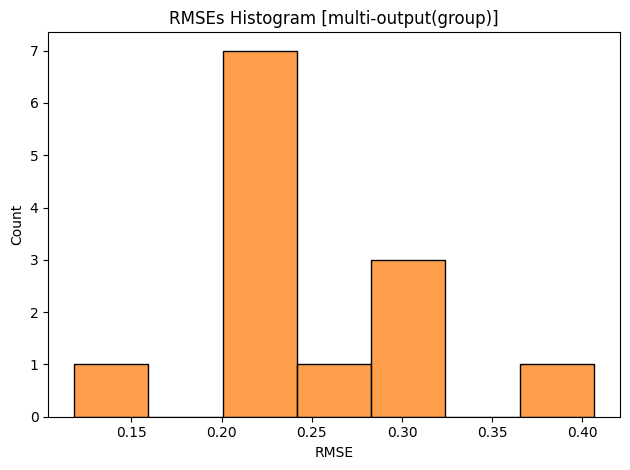

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


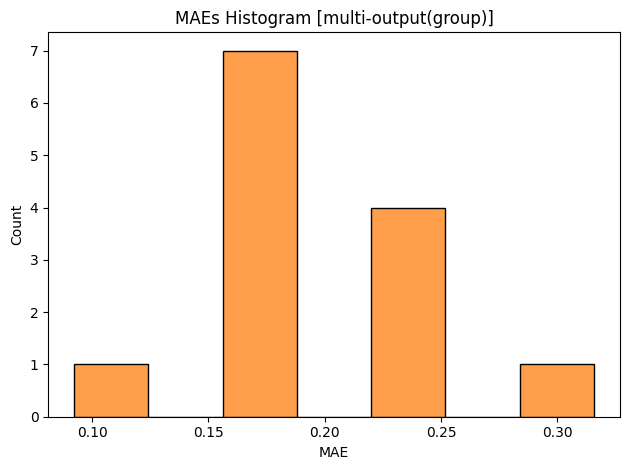

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


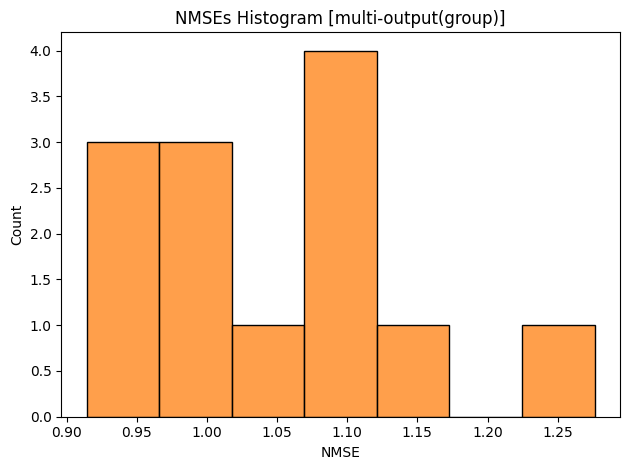

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
dicio = {'regchain': {'color': class_palette[0], 'code': 'rc'},
         'multi-rforest': {'color': class_palette[1], 'code': 'mrf'},
         'multi-output': {'color': class_palette[2], 'code': 'mor'},
         'regchain(group)': {'color': class_palette[3], 'code': 'rcg'},
         'multi-rforest(group)': {'color': class_palette[4], 'code': 'mrfg'}}

for a in dicio.keys():
    for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/heart/imgs/hg_{dicio[a]['code']}_{mt.lower()}.eps', format='eps', dpi=300)

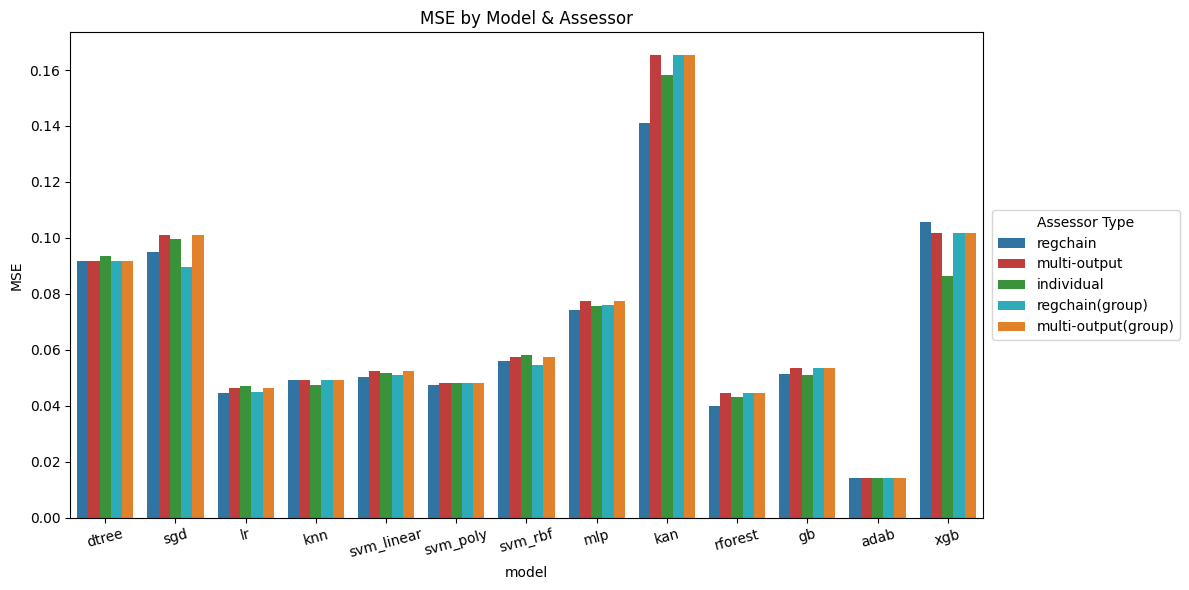

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


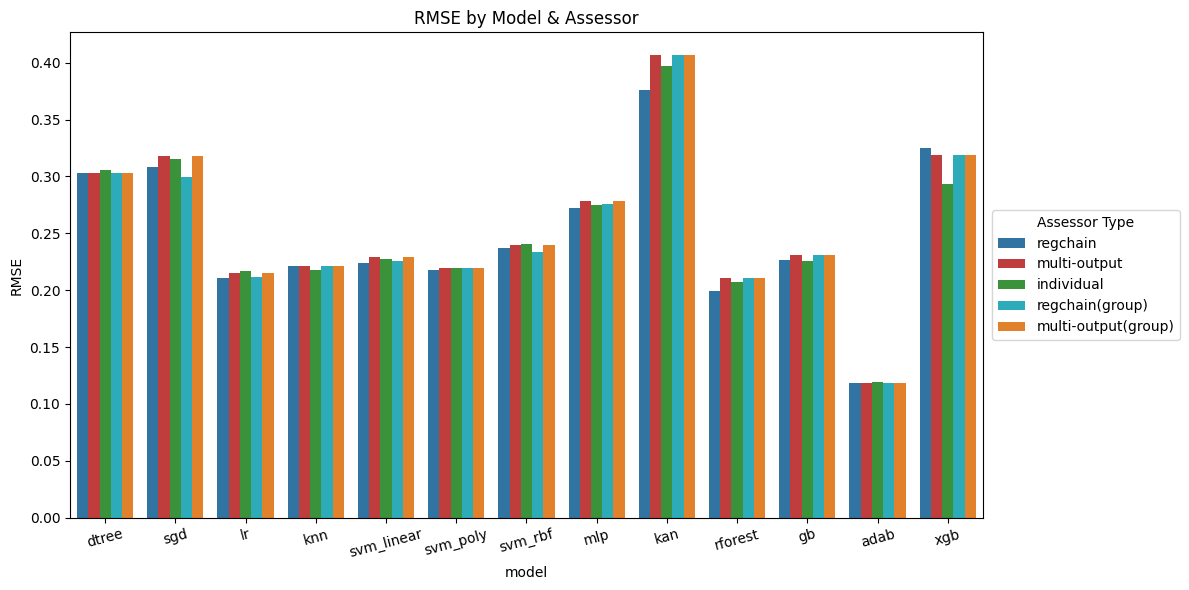

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


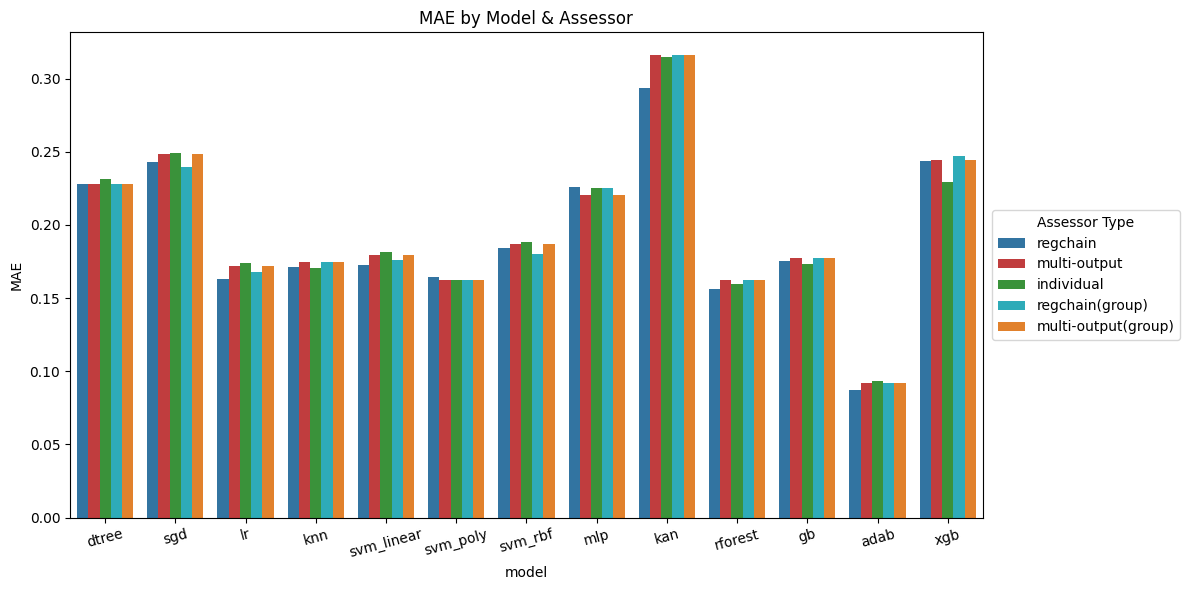

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


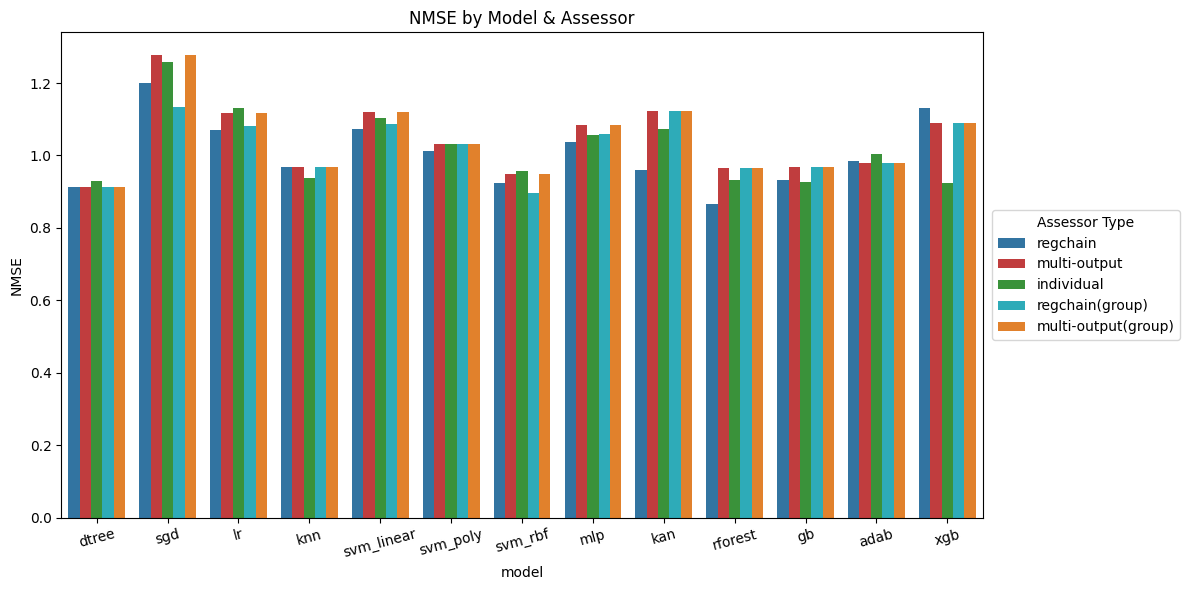

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [124]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/heart/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)